# Data Mining Project
#### *Danilo Najkov 206033*
## Dataset introduction
I created my dataset by scraping the website [cars.com](https://www.cars.com/shopping/results/?stock_type=used&makes%5B%5D=&models%5B%5D=&list_price_max=&maximum_distance=20&zip=) on used cars. I managed to scrape 1094 different listed cars with 20 features each, and additionaly created some more features in the step Cleaning and feature engineering. There is a mix of continuous and discrete data, with missing values and outliers. More information about each of the features can be found in the EDA section.

*The code used for scraping is attached in a seperate file - scraping.py*

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import pandas as pd
import numpy as np
from sklearn.feature_selection import mutual_info_regression as mi_reg

df = pd.read_csv('/content/drive/MyDrive/full_data.csv').drop(['Unnamed: 0'], axis=1)
df = df[df.price!='Not Priced']
df.head()

,price,name,ext_color,int_color,drivetrain,mpg,fuel,transmission,engine,mileage,accidents,1owner,personal_use,review_comfort,review_design,review_performance,review_value,review_styling,review_reliability,sellers-notes
0,"$33,991",2022 Subaru Ascent Premium 8-Passenger,Crystal Black Silica,Ivory,All-wheel Drive,21–27,Gasoline,Automatic CVT,2.4L H4 16V GDI DOHC Turbo,"13,955 mi.",None reported,Yes,Yes,4.5,4.4,3.8,3.9,4.0,4.2,"Clean CARFAX. CARFAX One-Owner. Backup Camera,..."
1,"$25,400",2020 Toyota Camry Hybrid XLE,Blue,Black,Front-wheel Drive,44–47,Hybrid,Automatic CVT,2.5L I4 16V PDI DOHC Hybrid,"93,794 mi.",None reported,Yes,No,4.9,4.8,4.4,4.4,4.9,4.6,"Come see us in beautiful Ardmore, OK USA! Take..."
2,"$58,604",2022 Ford Bronco Outer Banks,Shadow Black,Roast,Four-wheel Drive,20–21,Gasoline,10-Speed Automatic,2.7L V6 24V GDI DOHC Turbo,"6,440 mi.",None reported,Yes,Yes,4.6,4.7,4.8,4.2,4.9,4.3,New Price! CARFAX One-Owner. Bronco BALANCE OF...
3,"$27,777",2021 Chevrolet Blazer 2LT,Silver Ice Metallic,Jet Black,All-wheel Drive,22–27,Gasoline,9-Speed Automatic,3.6L V6 24V GDI DOHC,"60,710 mi.",None reported,Yes,No,4.7,4.8,4.6,4.4,4.9,4.5,"Wifi Hotspot, AWD, Apple CarPlay/Android Auto,..."
4,"$54,894",2023 Acura MDX A-Spec,Fathom Blue Pearl,Ebony,All-wheel Drive,19–25,Gasoline,10-Speed Automatic,3.5L V6 24V GDI SOHC,"2,256 mi.",At least 1 accident or damage reported,Yes,Yes,NaN,NaN,NaN,NaN,NaN,NaN,2023 Acura MDX A-Spec SH-AWD Certified. NAVIGA...


In [ ]:
df.shape

(1094, 20)

# Cleaning and feature engineering

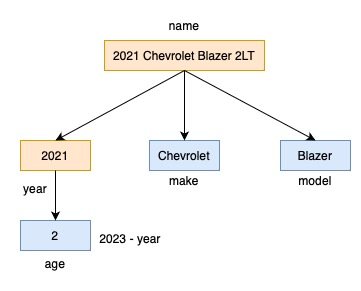

Created new and transformed existing features:
- New features from the `name` column:
  - age of car (ratio variable)
  - model of car (nominal variable)
  - make of car (nominal variable)
- Transformed the `miles per hour` coulumn as the average of the mpg range (ex. 26-30 becomes 28)
- New features of the `engine` column:
  - engine size - in liters (ratio variable)
  - engine type (nominal variable)
- Reduced the number of unique exterior and interior colors into more general ones.
- Cleaned `drivetrain` - (ex. AWD is the same as All-wheel Drive)
- Created a new general feature - `review` as a mean of all the other review columns. I did this because as I saw from the EDA, there is a high correlation between all the review features, so this change would help with reducing dimensionality without loosing much information. Also highly correlated input features cause problems for some models like Naive Bayes that assumes all features are independant.

The other transformations are minimal like replacing some chars, cating to integers, etc.


In [ ]:
import re

def clean_dataset():
  df_clean = df.copy()
  df_clean['price'] = df['price'].apply(lambda x: int(x[1:].replace(',','')))
  df_clean['year'] = df['name'].apply(lambda x: int(x[:4]))
  df_clean['year'] = df_clean['year'].apply(lambda x: 2023-x)
  df_clean['make'] = df['name'].apply(lambda x: x.split(' ')[1])
  df_clean['model'] = df['name'].apply(lambda x: x.split(' ')[2])

  def mpg_transform(mpg):
    if mpg == 'nan' or len(mpg.split('–'))<2:
      return np.nan
    a = int(mpg.split('–')[0])
    b = int(mpg.split('–')[1])
    if (a+b)/2 == 0:
      return np.nan
    return (a+b)/2

  df_clean['mpg'] = df['mpg'].astype(str).apply(mpg_transform)

  def engine_size_transform(engine):
    try:
      return float(engine.split(' ')[0][:-1])
    except:
      match = re.search(r'\d+\.\d+\s*L\s*', engine)
      if match:
        number_string = match.group()
        number = float(re.search(r'\d+\.\d+', number_string).group())
        return number
      else:
        match1 = re.search(r'\d+\s*L\s*', engine)
        if match1:
          number_string = match1.group()
          number = float(re.search(r'\d+', number_string).group())
          return number
        else:
          return np.nan

  def engine_type_transform(engine):
    match = re.search(r'\s([A-Z])[- ]?(\d)\s', engine)
    if match:
      letter = match.group(1)
      digit = match.group(2)
      if letter=='L':
        letter = 'I'
      return letter + digit
    else:
      if 'Cylinder' in engine:
        return 'V'+ engine.split('Cylinder')[0][0]
      else:
        return None

  df_clean['engine_size'] = df['engine'].apply(engine_size_transform)
  df_clean['engine_type'] = df['engine'].apply(engine_type_transform)

  colors = ['white', 'black', 'silver', 'blue', 'red', 'green', 'graphite', 'brown']


  def color_transform(color):
    if 'gray' in color.lower():
      return 'grey'
    for c in colors:
      if c in color.lower():
        return c
    return None

  df_clean['ext_color'] = df['ext_color'].apply(color_transform)
  df_clean['int_color'] = df['int_color'].apply(color_transform)

  def drivetrain_transform(dt):
    if dt=='AWD':
      return 'All-wheel Drive'
    if dt=='FWD':
      return 'Front-wheel Drive'
    if len(dt)<3:
      return None
    return dt

  df_clean['drivetrain'] = df['drivetrain'].apply(drivetrain_transform)

  def fuel_transform(fuel):
    if fuel=='Diesel' or fuel=='Electric' or fuel=='Hybrid' or fuel=='Gasoline':
      return fuel
    elif 'flex' in fuel.lower():
      return 'Gasoline'
    else:
      return None

  df_clean['fuel'] = df['fuel'].apply(fuel_transform)

  def mileage_transform(mileage):
    try:
      return int(mileage.split(' ')[0].replace(',',''))
    except:
      return np.nan

  df_clean['mileage'] = df['mileage'].apply(mileage_transform)

  def reviews_transform(review):
    try:
      return float(review)
    except:
      return np.nan

  df_clean['review_performance'] = df['review_performance'].apply(reviews_transform)
  df_clean['review_value'] = df['review_value'].apply(reviews_transform)
  df_clean['review_design'] = df['review_design'].apply(reviews_transform)
  df_clean['review_reliability'] = df['review_reliability'].apply(reviews_transform)
  df_clean['review_styling'] = df['review_styling'].apply(reviews_transform)
  df_clean['review_comfort'] = df['review_comfort'].apply(reviews_transform)

  df_clean['review'] = df_clean[['review_performance', 'review_value', 'review_design', 'review_reliability', 'review_styling', 'review_comfort']].mean(axis=1)

  return df_clean

In [ ]:
df_clean = clean_dataset()
df_clean.head()

,price,name,ext_color,int_color,drivetrain,mpg,fuel,transmission,engine,mileage,...,review_value,review_styling,review_reliability,sellers-notes,year,make,model,engine_size,engine_type,review
0,33991,2022 Subaru Ascent Premium 8-Passenger,black,None,All-wheel Drive,24.0,Gasoline,Automatic CVT,2.4L H4 16V GDI DOHC Turbo,13955.0,...,3.9,4.0,4.2,"Clean CARFAX. CARFAX One-Owner. Backup Camera,...",1,Subaru,Ascent,2.4,H4,4.133333
1,25400,2020 Toyota Camry Hybrid XLE,blue,black,Front-wheel Drive,45.5,Hybrid,Automatic CVT,2.5L I4 16V PDI DOHC Hybrid,93794.0,...,4.4,4.9,4.6,"Come see us in beautiful Ardmore, OK USA! Take...",3,Toyota,Camry,2.5,I4,4.666667
2,58604,2022 Ford Bronco Outer Banks,black,None,Four-wheel Drive,20.5,Gasoline,10-Speed Automatic,2.7L V6 24V GDI DOHC Turbo,6440.0,...,4.2,4.9,4.3,New Price! CARFAX One-Owner. Bronco BALANCE OF...,1,Ford,Bronco,2.7,V6,4.583333
3,27777,2021 Chevrolet Blazer 2LT,silver,black,All-wheel Drive,24.5,Gasoline,9-Speed Automatic,3.6L V6 24V GDI DOHC,60710.0,...,4.4,4.9,4.5,"Wifi Hotspot, AWD, Apple CarPlay/Android Auto,...",2,Chevrolet,Blazer,3.6,V6,4.650000
4,54894,2023 Acura MDX A-Spec,blue,None,All-wheel Drive,22.0,Gasoline,10-Speed Automatic,3.5L V6 24V GDI SOHC,2256.0,...,NaN,NaN,NaN,2023 Acura MDX A-Spec SH-AWD Certified. NAVIGA...,0,Acura,MDX,3.5,V6,NaN


In [ ]:
df_clean.columns

Index(['price', 'name', 'ext_color', 'int_color', 'drivetrain', 'mpg', 'fuel',
       'transmission', 'engine', 'mileage', 'accidents', '1owner',
       'personal_use', 'review_comfort', 'review_design', 'review_performance',
       'review_value', 'review_styling', 'review_reliability', 'sellers-notes',
       'year', 'make', 'model', 'engine_size', 'engine_type', 'review'],
      dtype='object')

# Missing values
Handled missing values for the following variables:
- ext_color and int_color: imputed with the mode because it is a nominal attribute
- drivetrain: same with the mode
- mpg: imputed with the mean because it is a continuies variable that follows the normal distribution
- fuel: imputed with the mode
- mileage: as this variable follows an exponential distribution, I modeled this distribution and generated values where it is missing from this distribution
- accidents, 1owner and personal_use: imputed with the mode. It dosen't matter much as only very few rows have missing this value
- review_x: for all the reviews i imputed with the median, as it is a skewed normal distribution with a few outliers
- engine_type: mode, as it is a nominal variable
- engine_size: median, as it is a continuous variable that doesn't follow the normal distribution

In [ ]:
df_clean.isnull().sum()

price                   0
name                    0
ext_color             148
int_color             400
drivetrain              6
mpg                   238
fuel                   46
transmission            0
engine                  0
mileage                39
accidents               8
1owner                 10
personal_use           10
review_comfort         92
review_design          92
review_performance     92
review_value           92
review_styling         92
review_reliability     96
sellers-notes          26
year                    0
make                    0
model                   0
engine_size            68
engine_type            76
review                 92
dtype: int64

In [ ]:
def missing_vals(df):
  mode_value = df['ext_color'].mode()[0]
  df['ext_color'].fillna(mode_value, inplace=True)

  mode_value = df['int_color'].mode()[0]
  df['int_color'].fillna(mode_value, inplace=True)

  mode_value = df['drivetrain'].mode()[0]
  df['drivetrain'].fillna(mode_value, inplace=True)

  mean_value = df['mpg'].mean()
  df['mpg'].fillna(mean_value, inplace=True)

  mode_value = df['fuel'].mode()[0]
  df['fuel'].fillna(mode_value, inplace=True)

  scale_param = 1.0 / df['mileage'].mean()
  missing_indices = df['mileage'].isnull()
  num_missing = sum(missing_indices)
  new_values = np.random.exponential(scale_param, size=num_missing)
  df.loc[missing_indices, 'mileage'] = new_values

  mode_value = df['accidents'].mode()[0]
  df['accidents'].fillna(mode_value, inplace=True)

  mode_value = df['1owner'].mode()[0]
  df['1owner'].fillna(mode_value, inplace=True)

  mode_value = df['personal_use'].mode()[0]
  df['personal_use'].fillna(mode_value, inplace=True)

  median_value = df['review_comfort'].median()
  df['review_comfort'].fillna(median_value, inplace=True)
  median_value = df['review_performance'].median()
  df['review_performance'].fillna(median_value, inplace=True)
  median_value = df['review_value'].median()
  df['review_value'].fillna(median_value, inplace=True)
  median_value = df['review_design'].median()
  df['review_design'].fillna(median_value, inplace=True)
  median_value = df['review_styling'].median()
  df['review_styling'].fillna(median_value, inplace=True)
  median_value = df['review_reliability'].median()
  df['review_reliability'].fillna(median_value, inplace=True)
  median_value = df['review'].median()
  df['review'].fillna(median_value, inplace=True)

  mode_value = df['engine_type'].mode()[0]
  df['engine_type'].fillna(mode_value, inplace=True)

  median_value = df['engine_size'].median()
  df['engine_size'].fillna(median_value, inplace=True)

missing_vals(df_clean)


In [ ]:
df_clean.to_csv("pr_full.csv")

# EDA

## General statistics, plots and correlation between the continous variables

In [ ]:
df_clean.describe()

,price,mpg,mileage,review_comfort,review_design,review_performance,review_value,review_styling,review_reliability,year,engine_size,review
count,1094.000000,1094.000000,1.094000e+03,1094.000000,1094.000000,1094.000000,1094.000000,1094.000000,1094.000000,1094.000000,1094.000000,1094.000000
mean,40491.561243,23.641939,5.021192e+04,4.646892,4.615539,4.614899,4.446984,4.736929,4.611335,5.469835,3.258501,4.610360
std,41706.033774,4.849992,4.440778e+04,0.308027,0.307181,0.335716,0.384947,0.236256,0.362919,5.451483,1.328144,0.260764
min,2995.000000,12.000000,1.757195e-07,3.000000,3.000000,3.000000,2.500000,3.000000,2.500000,0.000000,1.000000,3.400000
25%,22000.750000,20.500000,1.591300e+04,4.500000,4.500000,4.500000,4.300000,4.700000,4.500000,2.000000,2.000000,4.516667
50%,32727.500000,23.641939,3.899500e+04,4.700000,4.700000,4.700000,4.500000,4.800000,4.700000,4.000000,3.000000,4.666667
75%,46998.500000,25.500000,7.244175e+04,4.800000,4.800000,4.800000,4.700000,4.900000,4.800000,7.000000,3.600000,4.783333
max,649996.000000,55.500000,2.843100e+05,5.000000,5.000000,5.000000,5.000000,5.000000,5.000000,54.000000,8.400000,5.000000


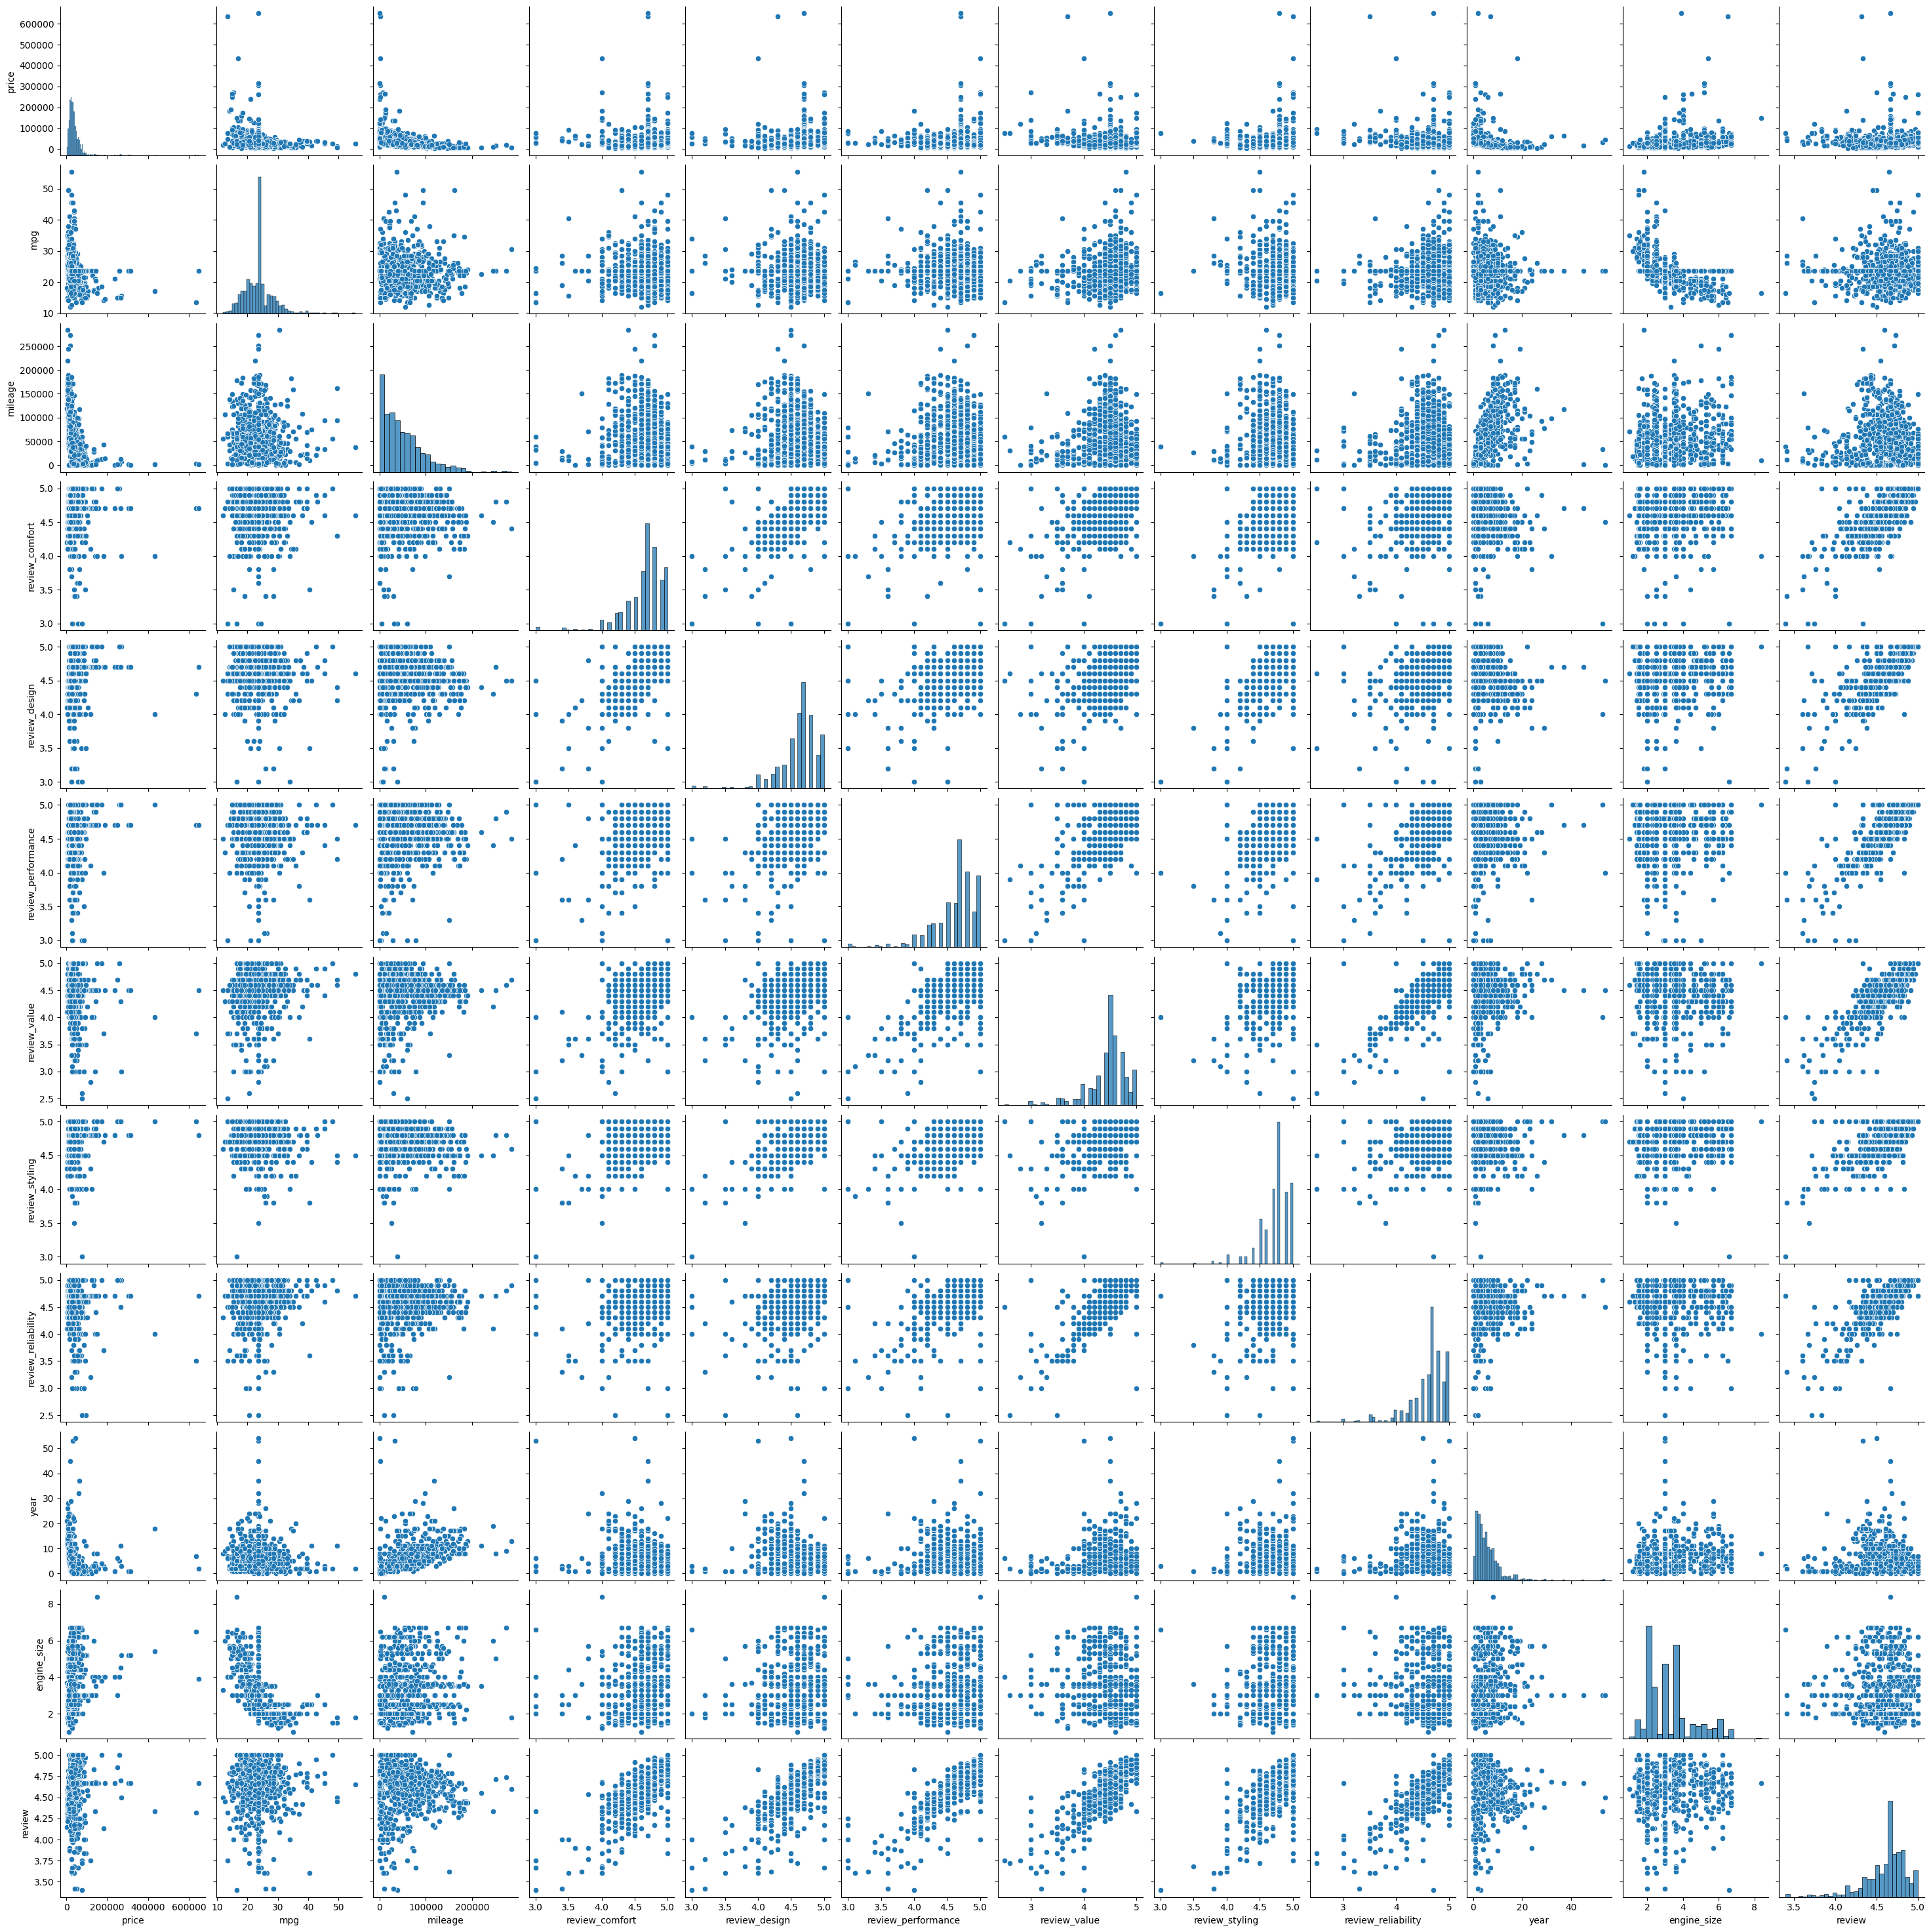

In [ ]:
import seaborn as sns
sns.pairplot(df_clean)

<ipython-input-17-ad10660149c3>:1: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  corr = df_clean.corr(method='spearman')


<Axes: >

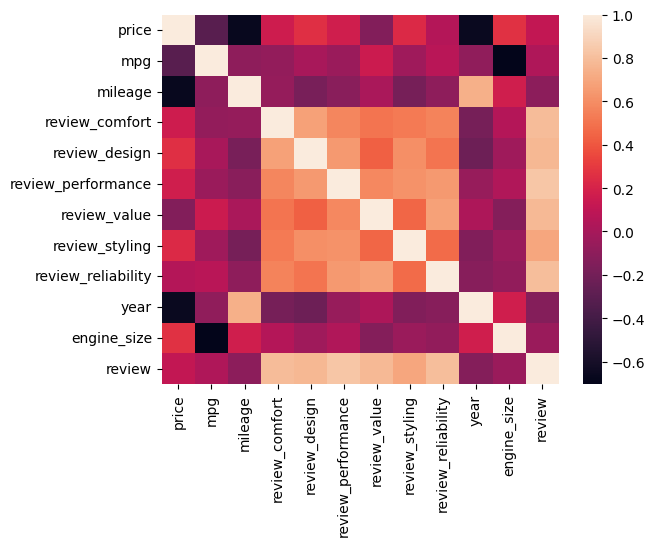

In [ ]:
corr = df_clean.corr(method='spearman')
sns.heatmap(corr,
        xticklabels=corr.columns,
        yticklabels=corr.columns)

## Per feature EDA and outliers

### Color (interior and exterior)
The color is a highly unbalanced nominal feature with most of the cars being white (and black for interior color). This is expected as also missing values were filled with white color as most common.

There is not much mutual information between the color and the price. I chose mutual information as a metric because the color is a nominal attribute.

<Axes: xlabel='ext_color'>

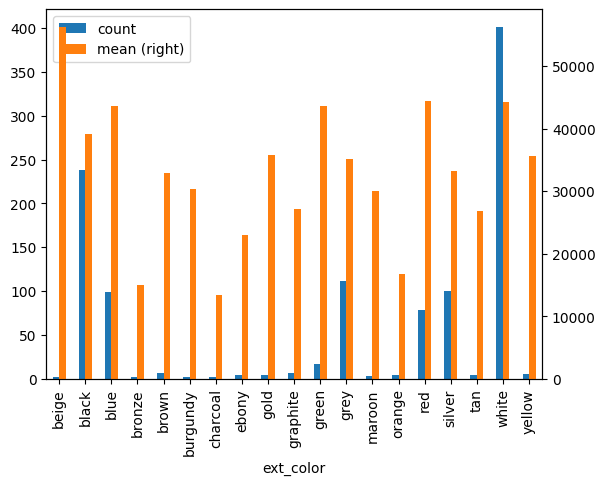

In [ ]:
df_clean.groupby('ext_color')['price'].agg(['count', 'mean']).plot(kind='bar', secondary_y='mean')

In [ ]:
ext_color_encoded = LabelEncoder().fit_transform(df_clean['ext_color'].to_numpy()).reshape(-1,1)
print(f"Mutual info: {mi_reg(ext_color_encoded, df_clean['price'])[0]}")

Mutual info: 0.0953662258348007


<Axes: xlabel='int_color'>

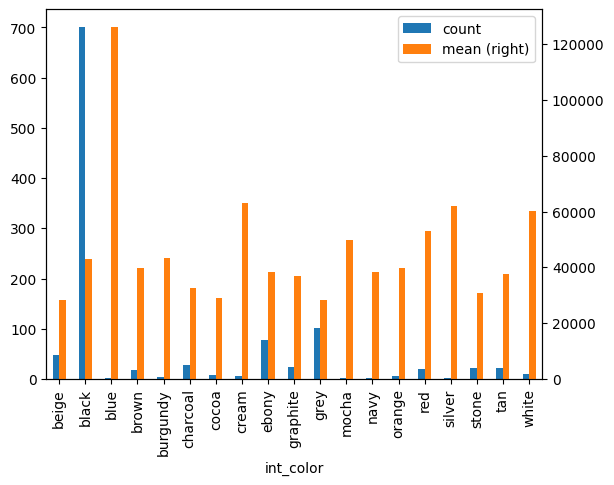

In [ ]:
df_clean.groupby('int_color')['price'].agg(['count', 'mean']).plot(kind='bar', secondary_y='mean')

In [ ]:
encoded = LabelEncoder().fit_transform(df_clean['int_color'].to_numpy()).reshape(-1,1)
print(f"Mutual info: {mi_reg(ext_color_encoded, df_clean['price'])[0]}")

Mutual info: 0.10161385552212088


### Drivetrain
Drivetrain is a relativly balanced nominal attribute. It shares little information with the price. I again chose mutual information because of the nominal type.

<Axes: xlabel='drivetrain'>

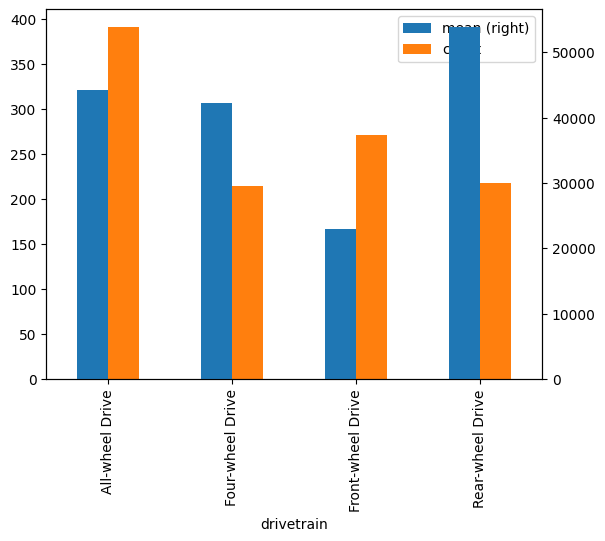

In [ ]:
df_clean.groupby('drivetrain')['price'].agg(['mean', 'count']).plot(kind='bar', secondary_y='mean')

In [ ]:
encoded = LabelEncoder().fit_transform(df_clean['drivetrain'].to_numpy()).reshape(-1,1)
print(f"Mutual info: {mi_reg(ext_color_encoded, df_clean['price'])[0]}")

Mutual info: 0.0966605600446524


### Miles per gallon
This is a ratio attribute. There isnt any clear linear correlation with the price, so I chose kendall correlation, as there are a few outliers. There is a slight negative correlation meaning as the car is more economical the price decreases.

The outliers aren't noise and must also be taken into account. As we can see from the below tables there are very efficent new cars and less efficent older or very powerfull cars, which makes sense

<Axes: xlabel='mpg', ylabel='price'>

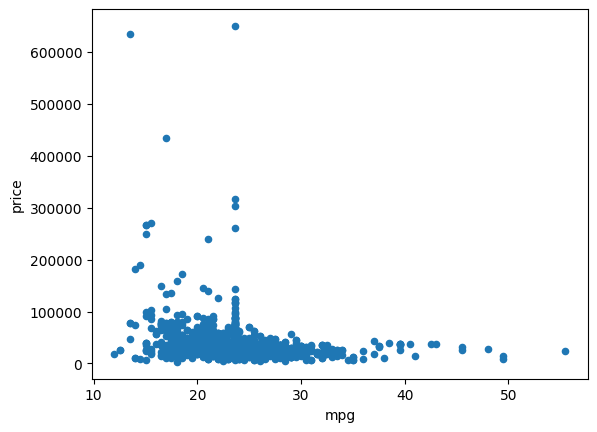

In [ ]:
df_clean.plot.scatter(x='mpg', y='price')

In [ ]:
print(f"Correlation: {df_clean['mpg'].corr(df_clean['price'], method='kendall')}")

Correlation: -0.24013223614815044


<Axes: >

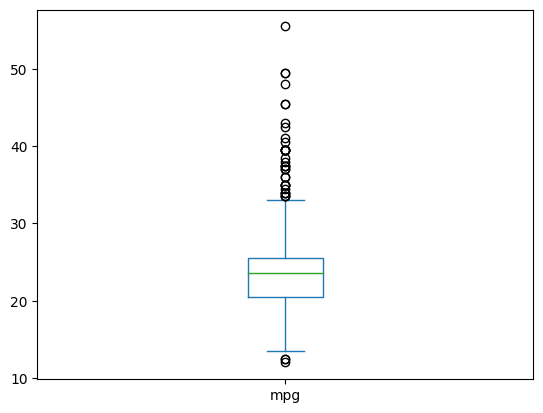

In [ ]:
df_clean['mpg'].plot.box()

In [ ]:
df_clean[df_clean['mpg']>37].head()

,price,name,ext_color,int_color,drivetrain,mpg,fuel,transmission,engine,mileage,...,review_value,review_styling,review_reliability,sellers-notes,year,make,model,engine_size,engine_type,review
1,25400,2020 Toyota Camry Hybrid XLE,blue,black,Front-wheel Drive,45.5,Hybrid,Automatic CVT,2.5L I4 16V PDI DOHC Hybrid,93794.0,...,4.4,4.9,4.6,"Come see us in beautiful Ardmore, OK USA! Take...",3,Toyota,Camry,2.5,I4,4.666667
79,32393,2021 Honda CR-V Hybrid EX,black,black,All-wheel Drive,37.5,Hybrid,Automatic CVT,2.0L I4 16V MPFI DOHC Hybrid,20440.0,...,4.7,4.8,4.8,Certified. CARFAX One-Owner. Clean CARFAX. Pri...,2,Honda,CR-V,2.0,I4,4.783333
123,39253,2021 Toyota Venza Limited,white,black,All-wheel Drive,38.5,Hybrid,Automatic CVT,2.5L I4 16V PDI DOHC Hybrid,21770.0,...,4.5,4.9,4.7,CARFAX One-Owner. Clean CARFAX. Certified. Tit...,2,Toyota,Venza,2.5,I4,4.683333
178,24977,2021 Toyota Prius L,grey,black,Front-wheel Drive,55.5,Hybrid,Automatic CVT,1.8L I4 16V MPFI DOHC Hybrid,37198.0,...,4.8,4.5,4.7,Our vehicles include Star Auto Mall 512 certif...,2,Toyota,Prius,1.8,I4,4.650000
340,14200,2012 Toyota Prius Five,white,black,Front-wheel Drive,49.5,Gasoline,Automatic,"1.8L I-4 DOHC, VVT-i variable valve control, e...",93902.0,...,4.6,4.4,4.8,Renn Kirby Kia is pleased to be currently offe...,11,Toyota,Prius,1.8,I4,4.500000


In [ ]:
df_clean[df_clean['mpg']<15].head()

,price,name,ext_color,int_color,drivetrain,mpg,fuel,transmission,engine,mileage,...,review_value,review_styling,review_reliability,sellers-notes,year,make,model,engine_size,engine_type,review
48,8995,2011 Land Rover LR4 Base,brown,black,Four-wheel Drive,14.5,Gasoline,Automatic,"5L V-8 gasoline direct injection, DOHC, variab...",134120.0,...,4.1,4.6,4.5,An interior with purpose. The cabin of the Def...,12,Land,Rover,5.0,V8,4.566667
77,74988,2021 Lexus LX 570 Two-Row,white,black,Four-wheel Drive,14.0,Gasoline,8-Speed Automatic,5.7L V8 32V MPFI DOHC,30992.0,...,4.3,4.7,5.0,"CARFAX 1-Owner, Extra Clean, LOW MILES - 30,99...",2,Lexus,LX,5.7,V8,4.783333
82,181888,2020 Mercedes-Benz AMG G 63 Base,blue,blue,All-wheel Drive,14.0,Gasoline,9-Speed Automatic,4.0L V8 32V GDI DOHC Twin Turbo,43569.0,...,3.7,4.7,3.7,With over 250 Certified and Pre-Owned BMWs in ...,3,Mercedes-Benz,AMG,4.0,V8,4.133333
139,634900,2016 Lamborghini Aventador LP750-4 Superveloce,red,black,All-wheel Drive,13.5,Gasoline,7-Speed Automatic with Auto-Shift,6.5L V12 48V MPFI DOHC,2460.0,...,3.7,5.0,3.5,"A Roadster super sports car at its purest, des...",7,Lamborghini,Aventador,6.5,I4,4.316667
277,76988,2017 Mercedes-Benz G-Class G 550,black,black,All-wheel Drive,13.5,Gasoline,7-Speed Automatic,4.0L V8 32V GDI DOHC Twin Turbo,59500.0,...,2.5,5.0,4.5,2017 Mercedes-Benz G-Class G 550 4MATIC 2017 M...,6,Mercedes-Benz,G-Class,4.0,V8,3.750000


### Fuel type
Nominal attribute, so I chose mutual information. Nearly no mutual inforamtion found.

<Axes: xlabel='fuel'>

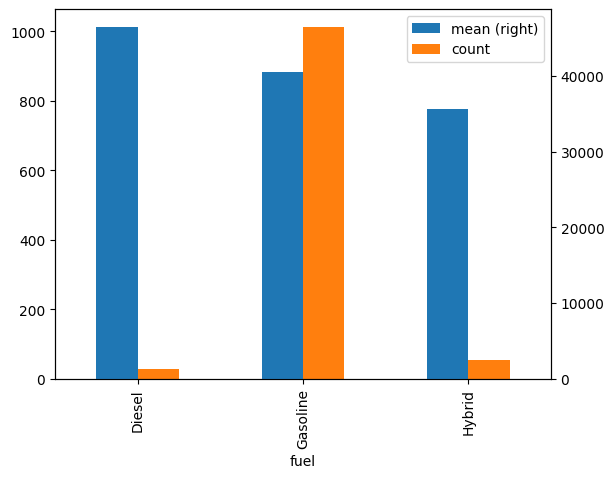

In [ ]:
df_clean.groupby('fuel')['price'].agg(['mean', 'count']).plot(kind='bar', secondary_y='mean')

In [ ]:
encoded = LabelEncoder().fit_transform(df_clean['fuel'].to_numpy()).reshape(-1,1)
print(f"Mutual info: {mi_reg(ext_color_encoded, df_clean['price'])[0]}")

Mutual info: 0.09898930868137668


### Mileage
Mileage is also a ratio attribute, and I again chose kendall correlation because of the outliers. There is quite stronger negative correlation meaning as the car has been used more the price decreases, which makes sense.

The outliers also make sense as there are cars that are driven a lot.

<Axes: xlabel='mileage', ylabel='price'>

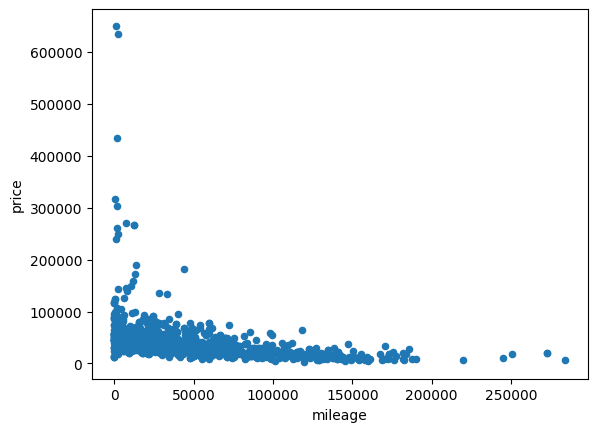

In [ ]:
df_clean.plot.scatter(x='mileage', y='price')

In [ ]:
print(f"Correlation: {df_clean['mileage'].corr(df_clean['price'], method='kendall')}")

Correlation: -0.6641344181842681


<Axes: >

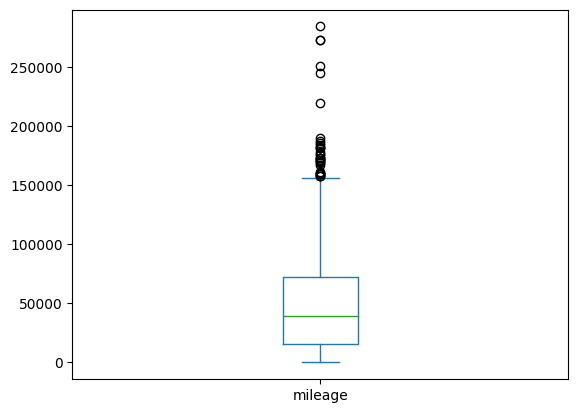

In [ ]:
df_clean['mileage'].plot.box()

In [ ]:
df_clean[df_clean['mileage']>250000].head()

,price,name,ext_color,int_color,drivetrain,mpg,fuel,transmission,engine,mileage,...,review_value,review_styling,review_reliability,sellers-notes,year,make,model,engine_size,engine_type,review
243,18000,2015 Ford F-150 Lariat,white,black,Four-wheel Drive,23.641939,Gasoline,6-Speed Automatic,5.0L V8 32V MPFI DOHC Flexible Fuel,250742.0,...,4.5,4.8,4.7,White 2015 Ford F-150 Lariat Recent Arrival! C...,8,Ford,F-150,5.0,V8,4.716667
479,7495,2010 Honda Civic LX,grey,black,Front-wheel Drive,30.500000,Gasoline,5-Speed Automatic,1.8L I4 16V MPFI SOHC,284310.0,...,4.7,4.6,4.9,Kelly and Kelly Auto. Located at 4677 Bragg Bl...,13,Honda,Civic,1.8,I4,4.600000
931,19500,2014 Ford F-250 Super Duty,white,black,Four-wheel Drive,23.641939,Diesel,6-Speed Automatic,6.7L V8 32V DDI OHV Turbo Diesel,273000.0,...,4.6,4.8,4.8,Along with the used vehicle you have been look...,9,Ford,F-250,6.7,V8,4.733333
1078,19500,2014 Ford F-250 Super Duty,white,black,Four-wheel Drive,23.641939,Diesel,6-Speed Automatic,6.7L V8 32V DDI OHV Turbo Diesel,273000.0,...,4.6,4.8,4.8,Along with the used vehicle you have been look...,9,Ford,F-250,6.7,V8,4.733333


### Accidents, 1owner and personal_use
Accidents, 1owner and personal_use are binary nominal attributes, so mutual information is chosen. Vey little mutual information found

<Axes: xlabel='accidents'>

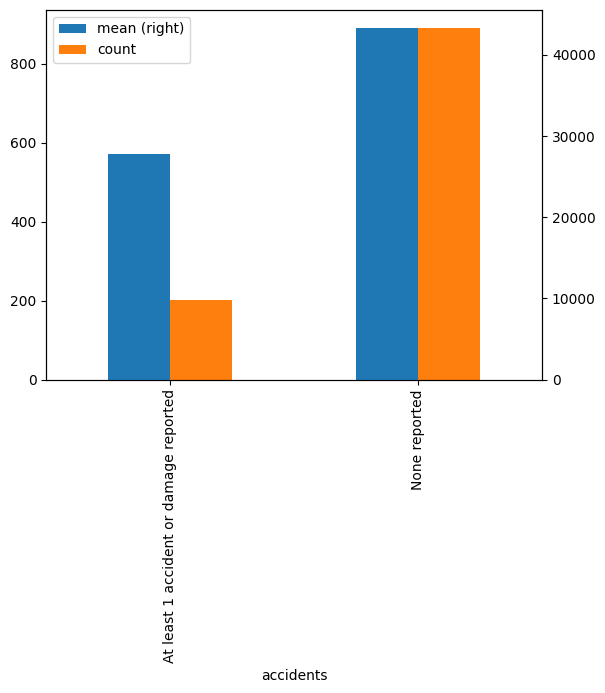

In [ ]:
df_clean.groupby('accidents')['price'].agg(['mean', 'count']).plot(kind='bar', secondary_y='mean')

In [ ]:
encoded = LabelEncoder().fit_transform(df_clean['accidents'].to_numpy()).reshape(-1,1)
print(f"Mutual info: {mi_reg(ext_color_encoded, df_clean['price'])[0]}")

Mutual info: 0.10032938903313027


<Axes: xlabel='1owner'>

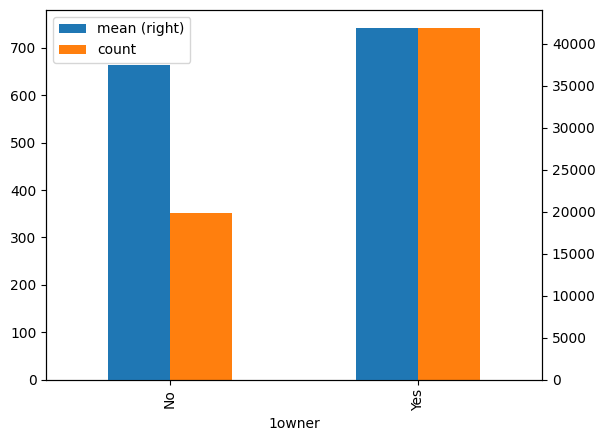

In [ ]:
df_clean.groupby('1owner')['price'].agg(['mean', 'count']).plot(kind='bar', secondary_y='mean')

In [ ]:
encoded = LabelEncoder().fit_transform(df_clean['1owner'].to_numpy()).reshape(-1,1)
print(f"Mutual info: {mi_reg(ext_color_encoded, df_clean['price'])[0]}")

Mutual info: 0.09797943994220026


<Axes: xlabel='personal_use'>

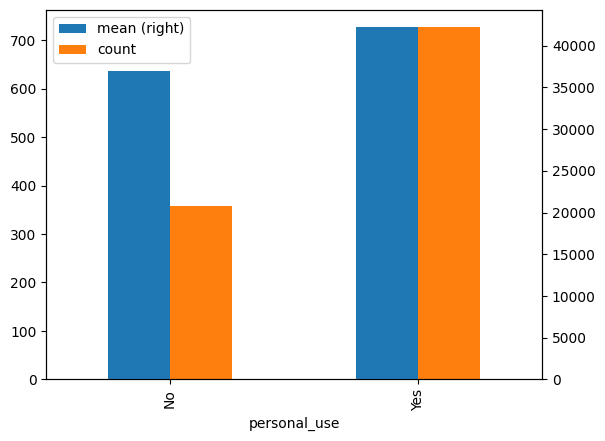

In [ ]:
df_clean.groupby('personal_use')['price'].agg(['mean', 'count']).plot(kind='bar', secondary_y='mean')

In [ ]:
encoded = LabelEncoder().fit_transform(df_clean['personal_use'].to_numpy()).reshape(-1,1)
print(f"Mutual info: {mi_reg(ext_color_encoded, df_clean['price'])[0]}")

Mutual info: 0.09968387336601836


### Reviews
Reviews is a continous - interval variable that ranges from 1-5, but all of the values fall in the range 3-5. I chose kendall correlation for this variable.

<Axes: xlabel='review_design', ylabel='price'>

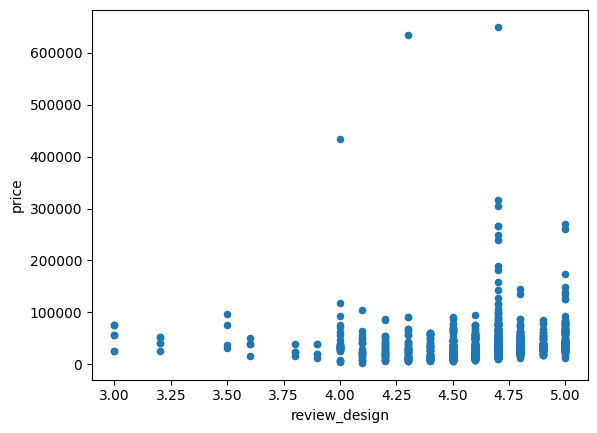

In [ ]:
df_clean.plot.scatter(x='review_design', y='price')

In [ ]:
print(f"Correlation: {df_clean['review'].corr(df_clean['price'], method='kendall')}")

Correlation: 0.18661085005067055


### Year
Interval variable, used kendall correlation, as there are outliers. Moderately high correlation indicating newer cars are more expensive

The outliers make sense as there are old cars - collectible or just very old that are on sale

<Axes: xlabel='year', ylabel='price'>

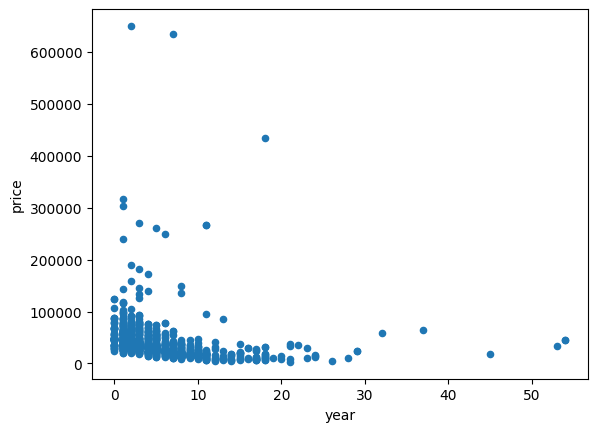

In [ ]:
df_clean.plot.scatter(x='year', y='price')

In [ ]:
print(f"Correlation: {df_clean['year'].corr(df_clean['price'], method='kendall')}")

Correlation: -0.4987831569254716


<Axes: >

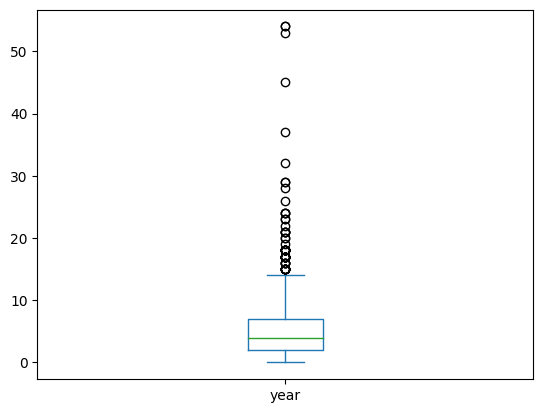

In [ ]:
df_clean['year'].plot.box()

In [ ]:
df_clean[df_clean['year']>40].head()

,price,name,ext_color,int_color,drivetrain,mpg,fuel,transmission,engine,mileage,...,review_value,review_styling,review_reliability,sellers-notes,year,make,model,engine_size,engine_type,review
593,45997,1969 Ford Mustang Base,white,black,All-wheel Drive,23.641939,Gasoline,–,–,558.0,...,4.5,5.0,4.5,1969 Ford Mustang Convertible 302 Why This Veh...,54,Ford,Mustang,3.0,I4,4.500000
605,32997,1970 Oldsmobile Cutlass,white,black,All-wheel Drive,23.641939,Gasoline,–,–,33415.0,...,4.0,5.0,5.0,1970 Oldsmobile Cutlass SX Why This Car Is Spe...,53,Oldsmobile,Cutlass,3.0,I4,4.333333
728,45997,1969 Ford Mustang Base,white,black,All-wheel Drive,23.641939,Gasoline,–,–,558.0,...,4.5,5.0,4.5,1969 Ford Mustang Convertible 302 Why This Veh...,54,Ford,Mustang,3.0,I4,4.500000
825,17999,1978 Chevrolet Camaro,blue,black,Rear-wheel Drive,23.641939,Gasoline,Automatic,V8,2153.0,...,4.5,4.8,4.7,"Once you’ve found the vehicle for you, work wi...",45,Chevrolet,Camaro,3.0,I4,4.666667


### Make of car
Used mutual information because it is a nominal variable. There isn't a high mutual information, but as it can be seen from the graph it is evident that some makes as Ferrari, Lamborghini have much higher prices, and others like Fiat, Honda are much more affordable, as expected.

<Axes: xlabel='make'>

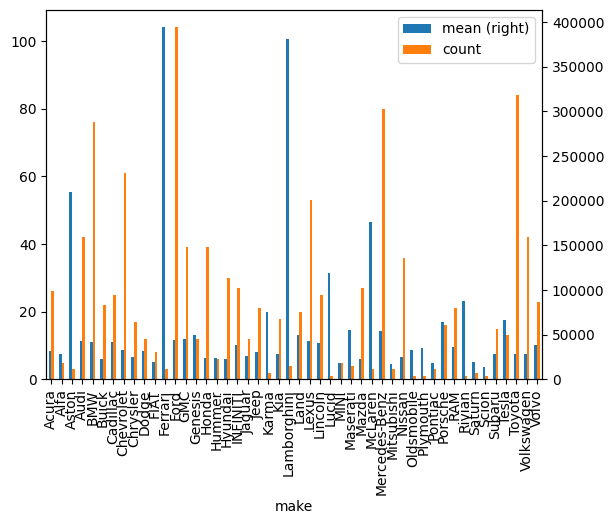

In [ ]:
df_clean.groupby('make')['price'].agg(['mean', 'count']).plot(kind='bar', secondary_y='mean')

In [ ]:
encoded = LabelEncoder().fit_transform(df_clean['make'].to_numpy()).reshape(-1,1)
print(f"Mutual info: {mi_reg(ext_color_encoded, df_clean['price'])[0]}")

Mutual info: 0.09598613056531335


### Engine size
Interval variable so i used spearmann's rank corellation as there aren't many outliers. Moderate correlation, depicting bigger engines results in pricier vehicles. Although not as high as I expected

A few outliers exist, like more powerfull cars with bigger eninges.

<Axes: xlabel='engine_size', ylabel='price'>

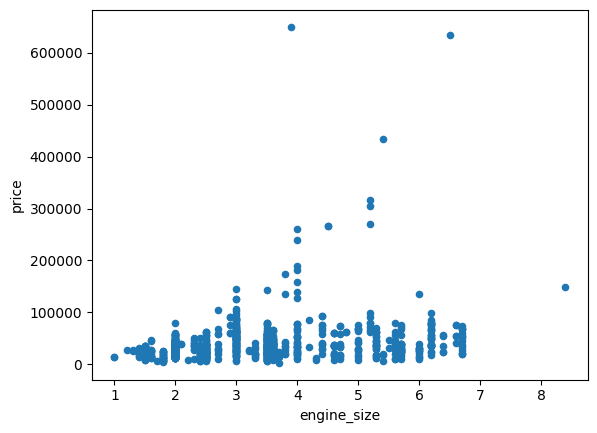

In [ ]:
df_clean.plot.scatter(x='engine_size', y='price')

In [ ]:
print(f"Correlation: {df_clean['engine_size'].corr(df_clean['price'], method='spearman')}")

Correlation: 0.2631907158698185


<Axes: >

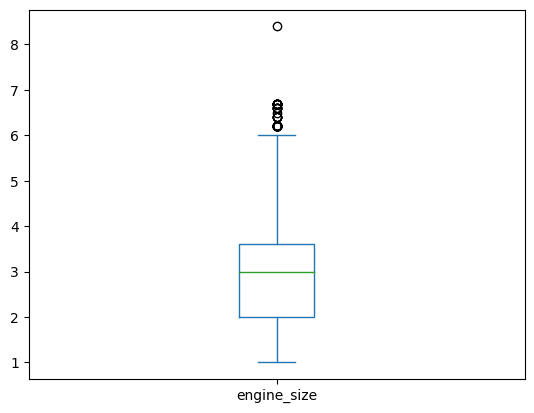

In [ ]:
df_clean['engine_size'].plot.box()

### Engine type
Nominal variable, used mutual information. Not much present.

<Axes: xlabel='engine_type'>

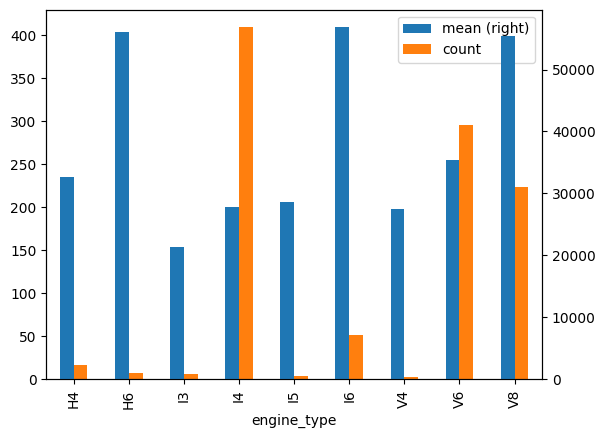

In [ ]:
df_clean.groupby('engine_type')['price'].agg(['mean', 'count']).plot(kind='bar', secondary_y='mean')

In [ ]:
encoded = LabelEncoder().fit_transform(df_clean['engine_type'].to_numpy()).reshape(-1,1)
print(f"Mutual info: {mi_reg(ext_color_encoded, df_clean['price'])[0]}")

Mutual info: 0.09696454622043804


# Regression of the price
Predicting the price can be useful for customers that have a car they want to sell and need an estimate for the price. Price is a ratio variable that follows a skewed normal distribution with outliers. The outliers arent noise, since expensive cars exist, so they can't be dropped and must be handled as well.

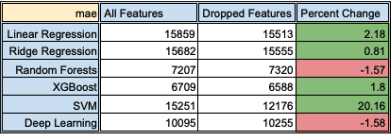

In [ ]:
df_clean.head()

,price,name,ext_color,int_color,drivetrain,mpg,fuel,transmission,engine,mileage,...,review_value,review_styling,review_reliability,sellers-notes,year,make,model,engine_size,engine_type,review
0,33991,2022 Subaru Ascent Premium 8-Passenger,black,black,All-wheel Drive,24.0,Gasoline,Automatic CVT,2.4L H4 16V GDI DOHC Turbo,13955.0,...,3.9,4.0,4.2,"Clean CARFAX. CARFAX One-Owner. Backup Camera,...",2022,Subaru,Ascent,2.4,H4,4.133333
1,25400,2020 Toyota Camry Hybrid XLE,blue,black,Front-wheel Drive,45.5,Hybrid,Automatic CVT,2.5L I4 16V PDI DOHC Hybrid,93794.0,...,4.4,4.9,4.6,"Come see us in beautiful Ardmore, OK USA! Take...",2020,Toyota,Camry,2.5,I4,4.666667
2,58604,2022 Ford Bronco Outer Banks,black,black,Four-wheel Drive,20.5,Gasoline,10-Speed Automatic,2.7L V6 24V GDI DOHC Turbo,6440.0,...,4.2,4.9,4.3,New Price! CARFAX One-Owner. Bronco BALANCE OF...,2022,Ford,Bronco,2.7,V6,4.583333
3,27777,2021 Chevrolet Blazer 2LT,silver,black,All-wheel Drive,24.5,Gasoline,9-Speed Automatic,3.6L V6 24V GDI DOHC,60710.0,...,4.4,4.9,4.5,"Wifi Hotspot, AWD, Apple CarPlay/Android Auto,...",2021,Chevrolet,Blazer,3.6,V6,4.650000
4,54894,2023 Acura MDX A-Spec,blue,ebony,All-wheel Drive,22.0,Gasoline,10-Speed Automatic,3.5L V6 24V GDI SOHC,2256.0,...,4.5,4.8,4.7,2023 Acura MDX A-Spec SH-AWD Certified. NAVIGA...,2023,Acura,MDX,3.5,V6,4.666667


<Axes: >

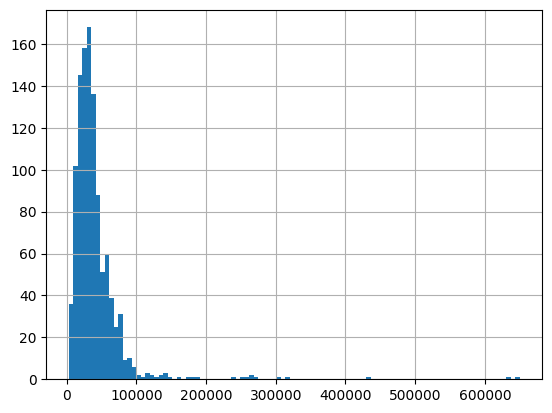

In [ ]:
df_clean['price'].hist(bins=100)

## Preprocessing
All of the categorical features are ordinal, so it is straightforward for them to be encoded with LabelEncoder (no custom encoding needed)

For the continous features I chose to scale them with StandardScaler.]

**Note:** This is a function I created to be used for all preprocessing in regression, classification and clustering. That is why samplers are included here

In [ ]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, StandardScaler, OrdinalEncoder
from imblearn.under_sampling import RandomUnderSampler
from imblearn.over_sampling import SMOTENC
from sklearn.cluster import AgglomerativeClustering
import numpy as np
import gower


def split_and_preprocess(df, drop_cols = ['name', 'engine', 'review_comfort', 'review_design', 'review_performance', 'review_value', 'review_styling', 'review_reliability', 'sellers-notes', 'transmission'], target='price', sample='none', test_size=0.2):
  df = df.drop(drop_cols, axis=1)
  if target != None:
    X_train, X_test, y_train, y_test = train_test_split(df.drop([target], axis=1), df[target], test_size=test_size)
  else:
    X_train = df.copy()
    X_test = df.copy()
    y_train = None
    y_test = None

  if sample != 'none':
    if sample == 'under':
      rus = RandomUnderSampler()
      X_train, y_train = rus.fit_resample(X_train, y_train)
    if sample == 'over':
      smote_enn = SMOTENC(sampling_strategy='auto', categorical_features=[1,2,3,5,7,8,10,11,13])
      X_train, y_train = smote_enn.fit_resample(X_train, y_train)
    if sample == 'cluster':
      cols = X_train.columns
      train_data = np.column_stack((X_train, y_train))
      majority_class = train_data[train_data[:, -1] == 'None reported']
      minority_class = train_data[train_data[:, -1] != 'None reported']

      num_clusters = 200
      dist_matrix = gower.gower_matrix(majority_class[:, :-1])
      clustering = AgglomerativeClustering(n_clusters=num_clusters, metric='precomputed', linkage='average').fit(dist_matrix)
      majority_clusters = clustering.fit_predict(dist_matrix)

      representative_samples = []
      for cluster_id in range(num_clusters):
          cluster_samples = majority_class[majority_clusters == cluster_id]
          if len(cluster_samples) > 0:
              representative_sample = cluster_samples[0]
              representative_samples.append(representative_sample)

      representative_samples = np.array(representative_samples)

      X_rep = representative_samples[:, :-1]
      y_rep = representative_samples[:, -1]

      X_train = pd.DataFrame(np.concatenate((X_rep, minority_class[:, :-1]), axis=0), columns=cols)
      y_train = np.concatenate((y_rep, minority_class[:, -1]), axis=0)

  if target!= 'ext_color' and 'ext_color' not in drop_cols:
    ext_color_encoder = OrdinalEncoder(handle_unknown='use_encoded_value', unknown_value=-1)
    X_train['ext_color'] = ext_color_encoder.fit_transform(X_train['ext_color'].to_numpy().reshape(-1,1))
    X_test['ext_color'] = ext_color_encoder.transform(X_test['ext_color'].to_numpy().reshape(-1,1))

  if target!= 'int_color' and 'int_color' not in drop_cols:
    int_color_encoder = OrdinalEncoder(handle_unknown='use_encoded_value', unknown_value=-1)
    X_train['int_color'] = int_color_encoder.fit_transform(X_train['int_color'].to_numpy().reshape(-1,1))
    X_test['int_color'] = int_color_encoder.transform(X_test['int_color'].to_numpy().reshape(-1,1))

  if target!= 'drivetrain' and 'drivetrain' not in drop_cols:
    drivetrain_encoder = LabelEncoder()
    X_train['drivetrain'] = drivetrain_encoder.fit_transform(X_train['drivetrain'])
    X_test['drivetrain'] = drivetrain_encoder.transform(X_test['drivetrain'])

  if target!= 'fuel' not in drop_cols:
    fuel_encoder = LabelEncoder()
    X_train['fuel'] = fuel_encoder.fit_transform(X_train['fuel'])
    X_test['fuel'] = fuel_encoder.transform(X_test['fuel'])

  if target!= 'accidents' and 'accidents' not in drop_cols:
    accidents_encoder = LabelEncoder()
    X_train['accidents'] = accidents_encoder.fit_transform(X_train['accidents'])
    X_test['accidents'] = accidents_encoder.transform(X_test['accidents'])

  if '1owner' not in drop_cols:
    owner_encoder = LabelEncoder()
    X_train['1owner'] = owner_encoder.fit_transform(X_train['1owner'])
    X_test['1owner'] = owner_encoder.transform(X_test['1owner'])

  if 'personal_use' not in drop_cols:
    personal_encoder = LabelEncoder()
    X_train['personal_use'] = personal_encoder.fit_transform(X_train['personal_use'])
    X_test['personal_use'] = personal_encoder.transform(X_test['personal_use'])

  if 'year' not in drop_cols:
    review_scaler = StandardScaler()
    X_train['year'] = review_scaler.fit_transform(X_train['year'].to_numpy().reshape(-1, 1))
    X_test['year'] = review_scaler.transform(X_test['year'].to_numpy().reshape(-1, 1))

  if 'model' not in drop_cols:
    model_encoder = OrdinalEncoder(handle_unknown='use_encoded_value', unknown_value=-1)
    X_train['model'] = model_encoder.fit_transform(X_train['model'].to_numpy().reshape(-1,1))
    X_test['model'] = model_encoder.transform(X_test['model'].to_numpy().reshape(-1,1))

  if 'make' not in drop_cols:
    make_encoder = OrdinalEncoder(handle_unknown='use_encoded_value', unknown_value=-1)
    X_train['make'] = make_encoder.fit_transform(X_train['make'].to_numpy().reshape(-1,1))
    X_test['make'] = make_encoder.transform(X_test['make'].to_numpy().reshape(-1,1))

  if 'engine_type' not in drop_cols:
    engine_encoder = OrdinalEncoder(handle_unknown='use_encoded_value', unknown_value=-1)
    X_train['engine_type'] = engine_encoder.fit_transform(X_train['engine_type'].to_numpy().reshape(-1,1))
    X_test['engine_type'] = engine_encoder.transform(X_test['engine_type'].to_numpy().reshape(-1,1))

  if 'mpg' not in drop_cols:
    mpg_scaler = StandardScaler()
    X_train['mpg'] = mpg_scaler.fit_transform(X_train['mpg'].to_numpy().reshape(-1, 1))
    X_test['mpg'] = mpg_scaler.transform(X_test['mpg'].to_numpy().reshape(-1, 1))

  if 'mileage' not in drop_cols:
    mileage_scaler = StandardScaler()
    X_train['mileage'] = mileage_scaler.fit_transform(X_train['mileage'].to_numpy().reshape(-1, 1))
    X_test['mileage'] = mileage_scaler.transform(X_test['mileage'].to_numpy().reshape(-1, 1))

  if 'review' not in drop_cols:
    review_scaler = StandardScaler()
    X_train['review'] = review_scaler.fit_transform(X_train['review'].to_numpy().reshape(-1, 1))
    X_test['review'] = review_scaler.transform(X_test['review'].to_numpy().reshape(-1, 1))

  if 'engine_size' not in drop_cols:
    engsize_scaler = StandardScaler()
    X_train['engine_size'] = engsize_scaler.fit_transform(X_train['engine_size'].to_numpy().reshape(-1, 1))
    X_test['engine_size'] = engsize_scaler.transform(X_test['engine_size'].to_numpy().reshape(-1, 1))

  if target!='price':
    price_scaler = StandardScaler()
    X_train['price'] = price_scaler.fit_transform(X_train['price'].to_numpy().reshape(-1, 1))
    X_test['price'] = price_scaler.transform(X_test['price'].to_numpy().reshape(-1, 1))


  return X_train, X_test, y_train, y_test


In [ ]:
X_train, X_test, y_train, y_test = split_and_preprocess(df_clean)

## Models

### Linear regression
The most basic linear regression model performs very bad, and on average misses the correct value by 14208$ which is quite a lot. Perhaps this model is way to simple to capture the complexity of the problem, or the model fits to the large number of outliers.

I used f_regression to get the the significance of the features in the model. I combined these findings with the feature importances from the random forest model to retrain the models on the more important/significant features

In [ ]:
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_absolute_error as mae, r2_score

reg = LinearRegression()
reg.fit(X_train, y_train)
y_pred_test = reg.predict(X_test)

print('TEST ERROR')
print(f'Mean absolute error: {mae(y_test, y_pred_test)}')

TEST ERROR
Mean absolute error: 15859.023027285823


In [ ]:
from sklearn.feature_selection import f_regression
from scipy import stats

f_scores, p_values = f_regression(X_train, y_train)
significant_variables = X_train.columns[p_values < 0.05]
non_significant_variables = X_train.columns[p_values >= 0.05]
print(f'significant: {significant_variables}')
print(f'non-significant: {non_significant_variables}')
print(f'p_vals: {p_values}')

significant: Index(['mpg', 'mileage', 'accidents', 'personal_use', 'year', 'engine_size',
       'engine_type'],
      dtype='object')
non-significant: Index(['ext_color', 'int_color', 'drivetrain', 'fuel', '1owner', 'make',
       'model', 'review'],
      dtype='object')
p_vals: [4.75030714e-01 4.45720675e-01 4.39722386e-01 1.02101382e-12
 1.48646909e-01 1.18445802e-29 7.07209433e-06 3.75192361e-01
 3.51187213e-02 3.60541559e-09 2.23599245e-01 3.15079629e-01
 5.11580248e-13 1.35252268e-03 8.50042400e-01]


### Ridge regression
Ridge regression manages to lower the error with high enough alpha penalization. I decided to use it because of the multicolinearility and the outliers. This might be becouse with a high alpha, the outliers are not as pronounced.

In [ ]:
from sklearn.linear_model import Ridge
from sklearn.metrics import mean_absolute_error as mae, r2_score

reg = Ridge(alpha=13)
reg.fit(X_train, y_train)
y_pred_test = reg.predict(X_test)

print('TEST ERROR')
print(f'Mean absolute error: {mae(y_test, y_pred_test)}')

TEST ERROR
Mean absolute error: 15682.459452256777


### Random forests
Random forests perform much better than linear regression models. I found the best score with adding max_depth to improve the generalization of the model.

Additionaly, we can extract the feature importances to see what features contributes the most in the models.

From here we can conclude that miles per gallon (efficency), mileage and engine size have biggest importances, with others like color, owner, accidents contribute very little

In [ ]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_absolute_error as mae, r2_score

reg = RandomForestRegressor(max_depth=13, n_estimators=300)
reg.fit(X_train, y_train)
y_pred_test = reg.predict(X_test)

print('TEST ERROR')
print(f'Mean absolute error: {mae(y_test, y_pred_test)}')

TEST ERROR
Mean absolute error: 7207.001367937145


In [ ]:
reg.feature_importances_

array([0.00885107, 0.00193047, 0.00882621, 0.17019601, 0.00120169,
       0.27892015, 0.00068528, 0.02048611, 0.01030929, 0.09042512,
       0.02968449, 0.05440059, 0.25502292, 0.04552368, 0.02353693])

In [ ]:
X_train.columns

Index(['ext_color', 'int_color', 'drivetrain', 'mpg', 'fuel', 'mileage',
       'accidents', '1owner', 'personal_use', 'year', 'make', 'model',
       'engine_size', 'engine_type', 'review'],
      dtype='object')

### Extreme gradient boosting (XGBOOST)
The default XGBoost managed to get a score worse than the random forests, but with tweaking the max_depth paramater was able to beat it. The lower max_depth limits the depth of each tree in the iterations, and prevents overfitting. XGBoost is generaly good with tabular data like this, and so performs good here as well.

In [ ]:
from xgboost import XGBRegressor
from sklearn.metrics import mean_absolute_error as mae, r2_score

reg = XGBRegressor(max_depth=15)
reg.fit(X_train, y_train)
y_pred_test = reg.predict(X_test)

print('TEST ERROR')
print(f'Mean absolute error: {mae(y_test, y_pred_test)}')

TEST ERROR
Mean absolute error: 6709.115363691495


### Support vector machines
SVMs do not produce good results, even after changing the parametars and trying with more complex kernels. This might be becouse SVMs are not very good with a lot of noisy, and irrelevant features, (from the random forests, we can see there are many). I repeat this experiment with fewer features after this section.

In [ ]:
from sklearn.svm import SVR
from sklearn.metrics import mean_absolute_error as mae, r2_score

reg = SVR(kernel='linear')
reg.fit(X_train, y_train)
y_pred_test = reg.predict(X_test)

print('TEST ERROR')
print(f'Mean absolute error: {mae(y_test, y_pred_test)}')

TEST ERROR
Mean absolute error: 15251.022362126883


### Deep learning
I chose mean absolute error becouse of the outliers. As if i chose mse, the error on those would be much higher, and would steer the model to catch those outliers and overfit. The best result for mae with various configurations and paramaters was around 13000, which is not good, considering xgboost and random forests did much better. This might be becouse these kind of models are very complex and require a lot more data than I have for this problem.

In [1]:
from keras.models import Sequential
from keras.layers import Dense, Dropout

model = Sequential()
model.add(Dense(32, input_dim=15, activation='relu'))
model.add(Dropout(0.1))
model.add(Dense(32, activation='relu'))
model.add(Dropout(0.1))
model.add(Dense(1, activation='linear'))

In [2]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 32)                512       
                                                                 
 dropout (Dropout)           (None, 32)                0         
                                                                 
 dense_1 (Dense)             (None, 32)                1056      
                                                                 
 dropout_1 (Dropout)         (None, 32)                0         
                                                                 
 dense_2 (Dense)             (None, 32)                1056      
                                                                 
 dense_3 (Dense)             (None, 1)                 33        
                                                                 
Total params: 2,657
Trainable params: 2,657
Non-trainabl

In [ ]:
model.compile(loss='mae', optimizer='adam', metrics=['mae'])
history = model.fit(X_train, y_train, epochs=130, batch_size=8, validation_data=(X_test, y_test))

Epoch 1/130
110/110 [==============================] - 2s 3ms/step - loss: 40817.5898 - mae: 40817.5898 - val_loss: 35557.1680 - val_mae: 35557.1680
Epoch 2/130
110/110 [==============================] - 1s 10ms/step - loss: 31303.0703 - mae: 31303.0703 - val_loss: 19863.4238 - val_mae: 19863.4238
Epoch 3/130
110/110 [==============================] - 0s 4ms/step - loss: 24016.6680 - mae: 24016.6680 - val_loss: 19434.4297 - val_mae: 19434.4297
Epoch 4/130
110/110 [==============================] - 1s 13ms/step - loss: 23377.6230 - mae: 23377.6230 - val_loss: 18971.6270 - val_mae: 18971.6270
Epoch 5/130
110/110 [==============================] - 0s 3ms/step - loss: 23030.4590 - mae: 23030.4590 - val_loss: 18376.6387 - val_mae: 18376.6387
Epoch 6/130
110/110 [==============================] - 0s 3ms/step - loss: 22518.9082 - mae: 22518.9082 - val_loss: 17839.7734 - val_mae: 17839.7734
Epoch 7/130
110/110 [==============================] - 0s 2ms/step - loss: 21976.7422 - mae: 21976.7422 

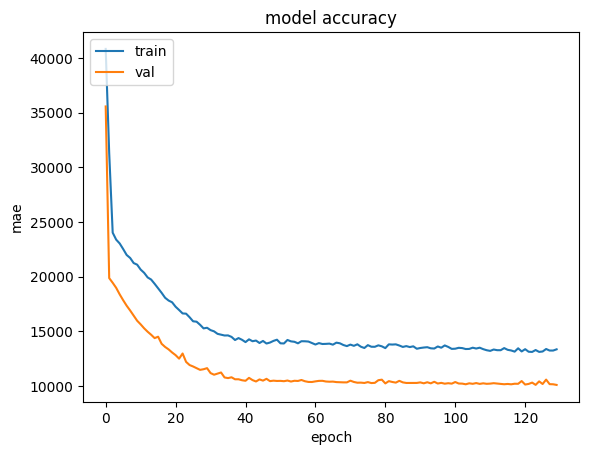

7/7 [==============================] - 0s 2ms/step
TEST ERROR
Mean absolute error: 10095.788915346746


In [ ]:
from matplotlib import pyplot as plt

plt.plot(history.history['mae'])
plt.plot(history.history['val_mae'])
plt.title('model accuracy')
plt.ylabel('mae')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

y_pred_test = model.predict(X_test)
print('TEST ERROR')
print(f'Mean absolute error: {mae(y_test, y_pred_test)}')

## Repeat the experiments on the models with dropping uninformative features
The reduction of noisy features improved the performance of some models:
- In the case of Linear regression, it improved the model by removing the features that added noise to the model and reduced the dimensionality.
- SVMs also had an improvment, since they also can't handle noisy unimportant features very well

But also some models, see no change:
- The tree based methods are the same because they are designed to learn what features are important, and give more importance to them. They can simply ignore uninformative features (with proper measures to avoid overfitting).
- The neural network also can indirectly choose which measures are important (by setting the weights for those features to lower values), and also create new features in its hidden layers. That is why they are also unaffected by this.


In [ ]:
X_train.drop(['ext_color', 'int_color', 'fuel', 'accidents', 'drivetrain'], axis=1, inplace=True)
X_test.drop(['ext_color', 'int_color', 'fuel', 'accidents', 'drivetrain'], axis=1, inplace=True)

In [ ]:
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_absolute_error as mae, r2_score

reg = LinearRegression()
reg.fit(X_train, y_train)
y_pred_test = reg.predict(X_test)

print('TEST ERROR')
print(f'Mean absolute error: {mae(y_test, y_pred_test)}')

TEST ERROR
Mean absolute error: 15613.346879404515


In [ ]:
from sklearn.linear_model import Ridge
from sklearn.metrics import mean_absolute_error as mae, r2_score

reg = Ridge(alpha=4)
reg.fit(X_train, y_train)
y_pred_test = reg.predict(X_test)

print('TEST ERROR')
print(f'Mean absolute error: {mae(y_test, y_pred_test)}')

TEST ERROR
Mean absolute error: 15555.217664557309


In [ ]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_absolute_error as mae, r2_score

reg = RandomForestRegressor(max_depth=18, n_estimators=300)
reg.fit(X_train, y_train)
y_pred_test = reg.predict(X_test)

print('TEST ERROR')
print(f'Mean absolute error: {mae(y_test, y_pred_test)}')

TEST ERROR
Mean absolute error: 7320.821891111394


In [ ]:
from xgboost import XGBRegressor
from sklearn.metrics import mean_absolute_error as mae, r2_score

reg = XGBRegressor(max_depth=5)
reg.fit(X_train, y_train)
y_pred_test = reg.predict(X_test)

print('TEST ERROR')
print(f'Mean absolute error: {mae(y_test, y_pred_test)}')

TEST ERROR
Mean absolute error: 6588.912365778396


In [ ]:
from sklearn.svm import SVR
from sklearn.metrics import mean_absolute_error as mae, r2_score

reg = SVR(kernel='linear', C=11)
reg.fit(X_train, y_train)
y_pred_test = reg.predict(X_test)

print('TEST ERROR')
print(f'Mean absolute error: {mae(y_test, y_pred_test)}')

TEST ERROR
Mean absolute error: 12176.302447461787


Epoch 1/130
110/110 [==============================] - 1s 3ms/step - loss: 40840.0703 - mae: 40840.0703 - val_loss: 35631.8711 - val_mae: 35631.8711
Epoch 2/130
110/110 [==============================] - 0s 2ms/step - loss: 32027.2773 - mae: 32027.2773 - val_loss: 20884.6973 - val_mae: 20884.6973
Epoch 3/130
110/110 [==============================] - 0s 2ms/step - loss: 24112.3789 - mae: 24112.3789 - val_loss: 19818.2129 - val_mae: 19818.2129
Epoch 4/130
110/110 [==============================] - 0s 2ms/step - loss: 23747.0645 - mae: 23747.0645 - val_loss: 19354.6699 - val_mae: 19354.6699
Epoch 5/130
110/110 [==============================] - 0s 2ms/step - loss: 23269.7207 - mae: 23269.7207 - val_loss: 18982.9961 - val_mae: 18982.9961
Epoch 6/130
110/110 [==============================] - 0s 2ms/step - loss: 22998.3379 - mae: 22998.3379 - val_loss: 18550.3477 - val_mae: 18550.3477
Epoch 7/130
110/110 [==============================] - 0s 2ms/step - loss: 22692.9609 - mae: 22692.9609 - 

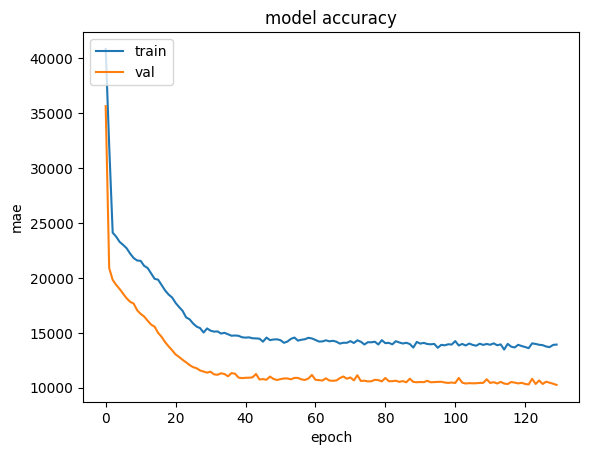

7/7 [==============================] - 0s 2ms/step
TEST ERROR
Mean absolute error: 10255.175660851884


In [ ]:
from keras.models import Sequential
from keras.layers import Dense, Dropout
from matplotlib import pyplot as plt

model = Sequential()
model.add(Dense(32, input_dim=10, activation='relu'))
model.add(Dropout(0.1))
model.add(Dense(32, activation='relu'))
model.add(Dropout(0.1))
model.add(Dense(32, activation='relu'))
model.add(Dense(1, activation='linear'))

model.compile(loss='mae', optimizer='adam', metrics=['mae'])
history = model.fit(X_train, y_train, epochs=130, batch_size=8, validation_data=(X_test, y_test))

plt.plot(history.history['mae'])
plt.plot(history.history['val_mae'])
plt.title('model accuracy')
plt.ylabel('mae')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

y_pred_test = model.predict(X_test)
print('TEST ERROR')
print(f'Mean absolute error: {mae(y_test, y_pred_test)}')

## Additional - NLP: Transformers
Main idea:

![image.png](https://miro.medium.com/v2/resize:fit:780/0*Oq3TJDs01KdWHHAj)

### Just text

In [ ]:
!pip install datasets transformers

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 474.6/474.6 kB 35.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.0/7.0 MB 104.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 212.5/212.5 kB 27.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.0/1.0 MB 65.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 224.5/224.5 kB 28.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 110.5/110.5 kB 15.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 134.3/134.3 kB 19.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.8/7.8 MB 109.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 114.5/114.5 kB 17.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 149.6/149.6 kB 22.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 268.8/268.8 kB 38.0 MB/s eta 0:00:00


In [ ]:
from datasets import load_dataset
from sklearn.model_selection import train_test_split

df_new = df_clean.dropna()
df_new['label'] = df_new['price']
df_new['label'] = df_new['label'].astype(float)

df_train, df_test = train_test_split(df_new, test_size=0.2)
df_train.to_csv('train.csv',index=False)
df_test.to_csv('test.csv',index=False)

dataset = load_dataset("csv", data_files={"train": "train.csv", "test": "test.csv"})

<ipython-input-9-9173c89e8d26>:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_new['label'] = df_new['price']
<ipython-input-9-9173c89e8d26>:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_new['label'] = df_new['label'].astype(float)


Extracting data files:   0%|          | 0/2 [00:00<?, ?it/s]

Generating train split: 0 examples [00:00, ? examples/s]

Generating test split: 0 examples [00:00, ? examples/s]

Dataset csv downloaded and prepared to /root/.cache/huggingface/datasets/csv/default-134cf524739da5c9/0.0.0/6954658bab30a358235fa864b05cf819af0e179325c740e4bc853bcc7ec513e1. Subsequent calls will reuse this data.


  0%|          | 0/2 [00:00<?, ?it/s]

In [ ]:
from transformers import AutoModelForSequenceClassification, TrainingArguments, AutoTokenizer, DataCollatorWithPadding

def tokenize_function(example):
    return tokenizer(example["sellers-notes"], example["name"], truncation=True)
tokenizer = AutoTokenizer.from_pretrained("bert-base-uncased")

tokenized_datasets = dataset.map(tokenize_function, batched=True)
data_collator = DataCollatorWithPadding(tokenizer=tokenizer)

training_args = TrainingArguments("test-trainer")

model = AutoModelForSequenceClassification.from_pretrained("bert-base-uncased", num_labels=1)

Map:   0%|          | 0/854 [00:00<?, ? examples/s]

Map:   0%|          | 0/214 [00:00<?, ? examples/s]

Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertForSequenceClassification: ['cls.seq_relationship.bias', 'cls.seq_relationship.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.decoder.weight', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.bias']
- This IS expected if you are initializing BertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at

In [ ]:
from transformers import Trainer

trainer = Trainer(
    model,
    training_args,
    train_dataset=tokenized_datasets["train"],
    eval_dataset=tokenized_datasets["test"],
    data_collator=data_collator,
    tokenizer=tokenizer,
)

trainer.train()

/usr/local/lib/python3.10/dist-packages/transformers/optimization.py:391: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(
You're using a BertTokenizerFast tokenizer. Please note that with a fast tokenizer, using the `__call__` method is faster than using a method to encode the text followed by a call to the `pad` method to get a padded encoding.


Step,Training Loss


TrainOutput(global_step=321, training_loss=3156699869.7071652, metrics={'train_runtime': 54.793, 'train_samples_per_second': 46.758, 'train_steps_per_second': 5.858, 'total_flos': 129998305241352.0, 'train_loss': 3156699869.7071652, 'epoch': 3.0})

In [ ]:
from sklearn.metrics import mean_absolute_error

predictions = trainer.predict(tokenized_datasets["train"])
preds = predictions.predictions.squeeze()

actuals = np.array(tokenized_datasets["train"]["label"])
mae = np.mean(np.abs(preds - actuals))
print("train MAE:", mae)

predictions = trainer.predict(tokenized_datasets["test"])
preds = predictions.predictions.squeeze()

actuals = np.array(tokenized_datasets["test"]["label"])
mae = np.mean(np.abs(preds - actuals))
print("test MAE:", mae)

train MAE: 39872.57841671937


test MAE: 44081.32269950225


### With addtional features

In [ ]:
!pip install multimodal_transformers

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 26.5/26.5 MB 45.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 880.6/880.6 kB 64.1 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.9/1.9 MB 66.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 15.9/15.9 MB 66.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 39.9/39.9 MB 18.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 11.5/11.5 MB 113.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 78.5/78.5 kB 12.0 MB/s eta 0:00:00
  Created wheel for sacremoses: filename=sacremoses-0.0.53-py3-none-any.whl size=895259 sha256=e6218055ddd57d05206e3bf885d0dde770b4c9f68fe58fa050552fbed291ea18
  Stored in directory: /root/.cache/pip/wheels/00/24/97/a2ea5324f36bc626e1ea0267f33db6aa80d157ee977e9e42fb
Successfully built sacremose

In [ ]:
import pandas as pd
from multimodal_transformers.data import load_data
from transformers import AutoTokenizer
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

text_cols = ['sellers-notes', 'name']
numerical_cols = ['mpg', 'mileage', 'engine_size']

tokenizer = AutoTokenizer.from_pretrained('bert-base-uncased')

df_new = df_clean.dropna()

scaler = StandardScaler()
df_new['mpg'] = scaler.fit_transform(df_new['mpg'].to_numpy().reshape(-1,1))
scaler = StandardScaler()
df_new['mileage'] = scaler.fit_transform(df_new['mileage'].to_numpy().reshape(-1,1))
scaler = StandardScaler()
df_new['engine_size'] = scaler.fit_transform(df_new['engine_size'].to_numpy().reshape(-1,1))

df_new['label'] = df_new['price']
df_new['label'] = df_new['label'].astype(float)
df_train, df_test = train_test_split(df_new, test_size=0.2)

train_dataset = load_data(
  df_train,
  text_cols,
  tokenizer,
  numerical_cols=numerical_cols,
  sep_text_token_str=tokenizer.sep_token,
  label_col='label'
)

test_dataset = load_data(
  df_test,
  text_cols,
  tokenizer,
  numerical_cols=numerical_cols,
  sep_text_token_str=tokenizer.sep_token,
  label_col='label'
)

<ipython-input-16-9eeeefbeb5e8>:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_new['mpg'] = scaler.fit_transform(df_new['mpg'].to_numpy().reshape(-1,1))
<ipython-input-16-9eeeefbeb5e8>:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_new['mileage'] = scaler.fit_transform(df_new['mileage'].to_numpy().reshape(-1,1))
<ipython-input-16-9eeeefbeb5e8>:19: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

S

In [ ]:
from multimodal_transformers.model import AutoModelWithTabular, TabularConfig
from transformers import AutoConfig

config = AutoConfig.from_pretrained('bert-base-uncased')
tabular_config = TabularConfig(
  num_labels=1,
  numerical_feat_dim=train_dataset.numerical_feats.shape[1],
  combine_feat_method='attention_on_cat_and_numerical_feats',
)
config.tabular_config = tabular_config
model = AutoModelWithTabular.from_pretrained('bert-base-uncased', config=config)

Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertWithTabular: ['cls.seq_relationship.bias', 'cls.seq_relationship.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.decoder.weight', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.bias']
- This IS expected if you are initializing BertWithTabular from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertWithTabular from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertWithTabular were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['tabular_

In [ ]:
from transformers import Trainer, TrainingArguments
training_args = TrainingArguments(
  output_dir="./logs/model_name",
  logging_dir="./logs/runs",
  overwrite_output_dir=True,
  do_train=True,
  num_train_epochs=1,
  per_device_eval_batch_size=8,
  per_device_train_batch_size=8,
  logging_steps=25,
)
trainer = Trainer(
  model=model,
  args=training_args,
  train_dataset=train_dataset,
  eval_dataset=test_dataset,
)
trainer.train()

/usr/local/lib/python3.10/dist-packages/transformers/optimization.py:391: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


Step,Training Loss
25,2506745937.920000
50,1971058769.920000
75,2977841152.000000
100,6897456250.880000


TrainOutput(global_step=107, training_loss=3478656516.7850466, metrics={'train_runtime': 30.6701, 'train_samples_per_second': 27.845, 'train_steps_per_second': 3.489, 'total_flos': 55681759885752.0, 'train_loss': 3478656516.7850466, 'epoch': 1.0})

In [ ]:
from sklearn.metrics import mean_absolute_error

predictions = trainer.predict(train_dataset)
preds = predictions.predictions
print(f"train MAE: {mean_absolute_error(predictions.label_ids, preds[0])}")

predictions = trainer.predict(test_dataset)
preds = predictions.predictions
print(f"test MAE: {mean_absolute_error(predictions.label_ids, preds[0])}")


train MAE: 40490.55513454991


test MAE: 41573.00524440659


# Classification accident
The goal is to predict if the car has been in an accident. This can be useful to detect fake/false postings and scams.
Accident is a binary attribute with imbalanced classes.

For evaluation the main metric I chose was f1 score with regard to the positive class (yes-accident), because it takes into account the recall and percision, as both false positives and false negatives are important.

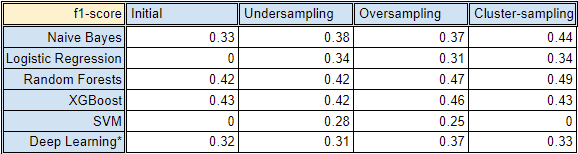

<Axes: >

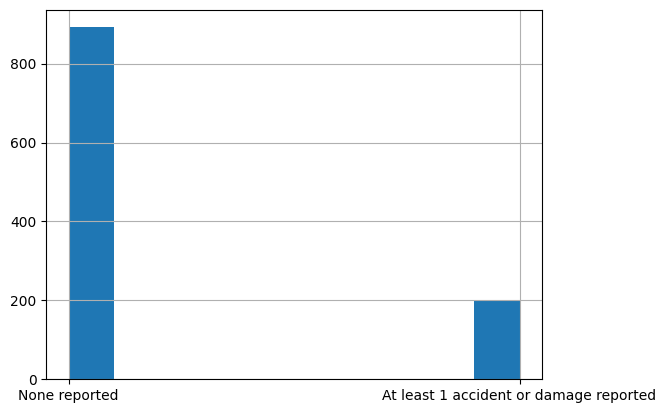

In [ ]:
df_clean['accidents'].hist()

## Models

In [ ]:
from sklearn.preprocessing import LabelEncoder

X_train, X_test, y_train, y_test = split_and_preprocess(df_clean, target='accidents')
enc = LabelEncoder()
y_train = enc.fit_transform(y_train)
y_test = enc.transform(y_test)

X_train.head()

,price,ext_color,int_color,drivetrain,mpg,fuel,mileage,1owner,personal_use,year,make,model,engine_size,engine_type,review
1086,0.608879,0.0,0.0,1,0.002623,0,0.787011,1,0,-0.281675,39.0,12.0,2.581350,5.0,-0.850471
1039,-0.007231,1.0,0.0,0,0.590676,1,-0.455950,0,0,-0.649809,32.0,128.0,-0.961384,3.0,-1.046820
758,-0.368679,0.0,4.0,3,-2.289859,1,1.265156,0,0,0.638660,13.0,241.0,2.053709,8.0,-0.654122
268,-0.557384,7.0,0.0,0,1.105057,1,0.077617,0,1,0.270526,4.0,7.0,-0.961384,3.0,0.131273
751,0.771820,7.0,0.0,1,0.002623,1,-0.954694,1,1,-1.017943,24.0,228.0,-0.207611,3.0,0.196723


### Naive bayes
Used a joint implementation of naive bayes as a baseline. The accuracy is better than the f1score which is because the imbalanced classes

In [ ]:
!pip install mixed-naive-bayes

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
from mixed_naive_bayes import MixedNB
from sklearn.metrics import accuracy_score, f1_score

clf = MixedNB(categorical_features=[1,2,3, 5,7,8,10,11,13])
clf.fit(X_train, y_train)
y_pred_test = clf.predict(X_test)

print('TEST ERROR')
print(f'Accuracy score: {accuracy_score(y_test, y_pred_test)}')
print(f'F1 score: {f1_score(y_test, y_pred_test, pos_label=0)}')

TEST ERROR
Accuracy score: 0.7442922374429224
F1 score: 0.3333333333333333


<Axes: >

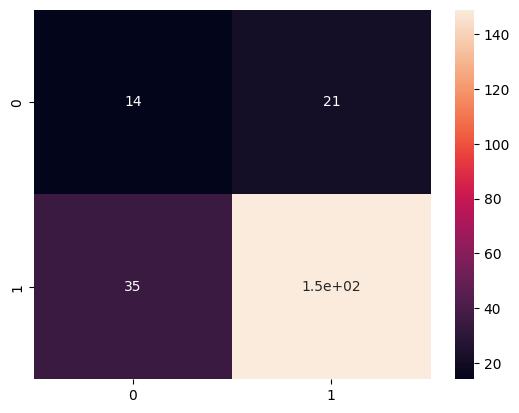

In [ ]:
from sklearn.metrics import confusion_matrix
import seaborn as sns

sns.heatmap(confusion_matrix(y_test, y_pred_test), annot=True)

### Logistic regression
Logistic regression has ok accuracy, but has f1-score of 0. This means that the classifier has overfitted and simply always predicts - no accident

In [ ]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, f1_score

clf = LogisticRegression(C=0.1, max_iter=10000)
clf.fit(X_train, y_train)
y_pred_test = clf.predict(X_test)

print('TEST ERROR')
print(f'Accuracy score: {accuracy_score(y_test, y_pred_test)}')
print(f'F1 score: {f1_score(y_test, y_pred_test, pos_label=0)}')

TEST ERROR
Accuracy score: 0.8356164383561644
F1 score: 0.0


<Axes: >

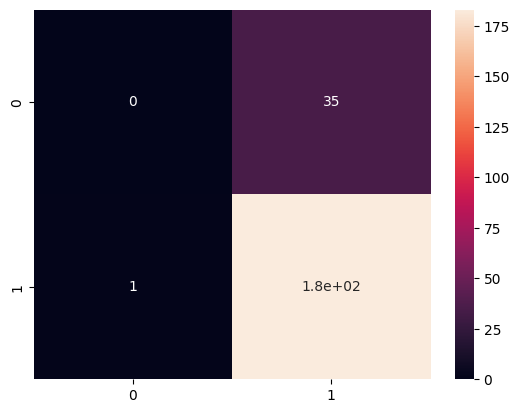

In [ ]:
sns.heatmap(confusion_matrix(y_test, y_pred_test), annot=True)

### Random forests
Random forests perform much better. Found the best score using entorpy as a criterion and adding a max_depth to improve generalization. Random forests perform better than the naive bayes becouse they can catch more complex relationships, while naive bayes assumes all featues are independant

In [ ]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, f1_score

clf = RandomForestClassifier(n_estimators=300, criterion='entropy', max_depth=11)
clf.fit(X_train, y_train)
y_pred_test = clf.predict(X_test)

print('TEST ERROR')
print(f'Accuracy score: {accuracy_score(y_test, y_pred_test)}')
print(f'F1 score: {f1_score(y_test, y_pred_test, pos_label=0)}')

TEST ERROR
Accuracy score: 0.863013698630137
F1 score: 0.4230769230769231


In [ ]:
clf.feature_importances_

array([0.14088134, 0.04461544, 0.02242658, 0.03850497, 0.08292364,
       0.00931869, 0.13633785, 0.02518543, 0.01511571, 0.1066347 ,
       0.08554634, 0.10142031, 0.06411696, 0.02835171, 0.09862035])

In [ ]:
X_train.columns

Index(['price', 'ext_color', 'int_color', 'drivetrain', 'mpg', 'fuel',
       'mileage', '1owner', 'personal_use', 'year', 'make', 'model',
       'engine_size', 'engine_type', 'review'],
      dtype='object')

<Axes: >

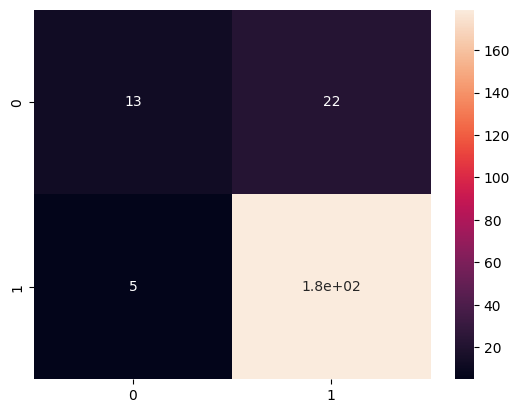

In [ ]:
sns.heatmap(confusion_matrix(y_test, y_pred_test), annot=True)

### XGBoost
XGBoost manages to achieve a better score than the random forests

In [ ]:
from xgboost import XGBClassifier
from sklearn.metrics import accuracy_score, f1_score

reg = XGBClassifier(max_depth=15)
reg.fit(X_train, y_train)
y_pred_test = reg.predict(X_test)

print('TEST ERROR')
print(f'Accuracy score: {accuracy_score(y_test, y_pred_test)}')
print(f'F1 score: {f1_score(y_test, y_pred_test, pos_label=0)}')

TEST ERROR
Accuracy score: 0.8310502283105022
F1 score: 0.4307692307692308


<Axes: >

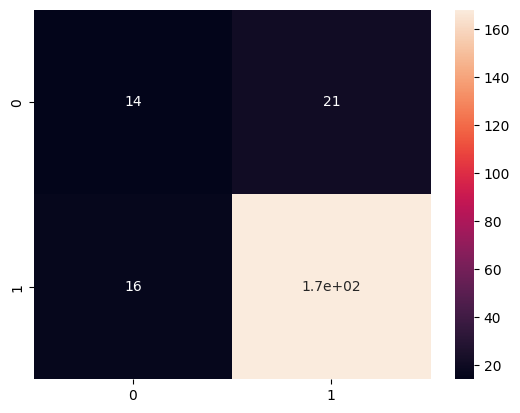

In [ ]:
sns.heatmap(confusion_matrix(y_test, y_pred_test), annot=True)

### Support vector machines
SVMs have the same issue as logistic regression as they train to predict only one class

In [ ]:
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score, f1_score

reg = SVC()
reg.fit(X_train, y_train)
y_pred_test = reg.predict(X_test)

print('TEST ERROR')
print(f'Accuracy score: {accuracy_score(y_test, y_pred_test)}')
print(f'F1 score: {f1_score(y_test, y_pred_test, pos_label=0)}')

TEST ERROR
Accuracy score: 0.8401826484018264
F1 score: 0.0


<Axes: >

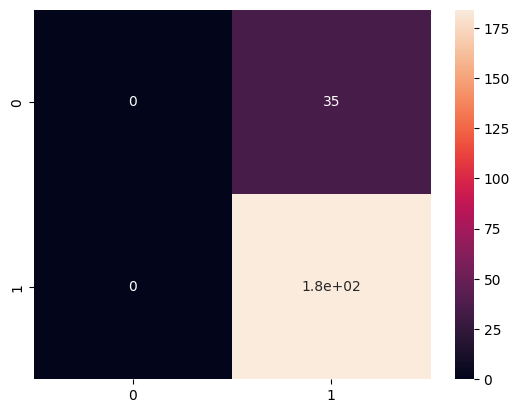

In [ ]:
sns.heatmap(confusion_matrix(y_test, y_pred_test), annot=True)

### Deep learning
Same problem as the other models with f1score of 0. But with weights (https://www.tensorflow.org/tutorials/structured_data/imbalanced_data) managed to get a score of 0.38

In [ ]:
weight_for_0 = (1 / len([el for el in y_train if el==0])) * (len(y_train) / 2.0)
weight_for_1 = (1 / len([el for el in y_train if el==1])) * (len(y_train) / 2.0)
class_weight = {0: weight_for_0, 1: weight_for_1}
class_weight

{0: 2.6197604790419162, 1: 0.6179378531073446}

In [ ]:
from keras.models import Sequential
from keras.layers import Dense, Dropout
import tensorflow as tf


model = Sequential()
model.add(Dense(64, input_dim=15, activation='relu'))
model.add(Dropout(0.1))
model.add(Dense(32, activation='relu'))
model.add(Dense(1, activation='sigmoid'))

model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['acc'])
history = model.fit(X_train, y_train, epochs=15, batch_size=8, validation_data=(X_test, y_test), class_weight=class_weight)

Epoch 1/15
110/110 [==============================] - 2s 6ms/step - loss: 1.7269 - acc: 0.5154 - val_loss: 1.0972 - val_acc: 0.3699
Epoch 2/15
110/110 [==============================] - 0s 4ms/step - loss: 1.2439 - acc: 0.5337 - val_loss: 1.1742 - val_acc: 0.3014
Epoch 3/15
110/110 [==============================] - 0s 4ms/step - loss: 1.0735 - acc: 0.5063 - val_loss: 0.7936 - val_acc: 0.4338
Epoch 4/15
110/110 [==============================] - 0s 4ms/step - loss: 0.9360 - acc: 0.5737 - val_loss: 0.8653 - val_acc: 0.4658
Epoch 5/15
110/110 [==============================] - 0s 4ms/step - loss: 0.8457 - acc: 0.5886 - val_loss: 0.5353 - val_acc: 0.7671
Epoch 6/15
110/110 [==============================] - 0s 4ms/step - loss: 0.8986 - acc: 0.5760 - val_loss: 0.9235 - val_acc: 0.3790
Epoch 7/15
110/110 [==============================] - 0s 3ms/step - loss: 0.8818 - acc: 0.5611 - val_loss: 0.8002 - val_acc: 0.4612
Epoch 8/15
110/110 [==============================] - 0s 3ms/step - loss: 0.

In [ ]:
y_pred_test = model.predict(X_test)
y_pred = list([0 if el[0]<=0.5 else 1 for el in y_pred_test])
print('TEST ERROR')
print(f'Accuracy score: {accuracy_score(y_test, y_pred)}')
print(f'F1 score: {f1_score(y_test, y_pred, pos_label=0)}')

7/7 [==============================] - 0s 2ms/step
TEST ERROR
Accuracy score: 0.6255707762557078
F1 score: 0.32786885245901637


<Axes: >

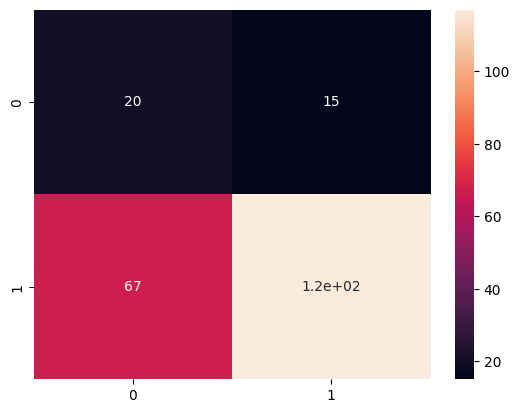

In [ ]:
sns.heatmap(confusion_matrix(y_test, y_pred), annot=True)

## Repeat the experiments with sampling the data to improve balance

### Undersampling
Undersampling managed to slightly improve the performace of the models and entirely eliminate the overfiting on one class of the SVMs and Logistic regression.

In [ ]:
from sklearn.preprocessing import LabelEncoder

X_train, X_test, y_train, y_test = split_and_preprocess(df_clean, target='accidents', sample='under')
enc = LabelEncoder()
y_train = enc.fit_transform(y_train)
y_test = enc.transform(y_test)

X_train.head()

,price,ext_color,int_color,drivetrain,mpg,fuel,mileage,1owner,personal_use,year,make,model,engine_size,engine_type,review
0,-0.718563,7.0,0.0,3,-0.118356,1,1.251313,1,1,1.412128,6.0,39.0,0.308977,7.0,-0.298337
1,-0.510005,7.0,3.0,3,-0.624281,1,-0.363676,0,0,-0.023190,32.0,1.0,1.885361,8.0,0.460492
2,-0.769642,0.0,3.0,2,1.601787,1,0.533257,1,1,0.386901,15.0,53.0,-1.042210,3.0,-0.677752
3,-0.515624,1.0,0.0,0,-0.624281,1,1.226802,1,1,0.386901,35.0,81.0,0.233911,7.0,0.308726
4,-0.540819,6.0,0.0,0,0.792308,1,-0.009880,0,1,0.181856,27.0,68.0,-0.892078,3.0,0.460492


In [ ]:
from mixed_naive_bayes import MixedNB
from sklearn.metrics import accuracy_score, f1_score

clf = MixedNB(categorical_features=[1,2,3, 5,7,8,10,11,13])
clf.fit(X_train, y_train)
y_pred_test = clf.predict(X_test)

print('TEST ERROR')
print(f'Accuracy score: {accuracy_score(y_test, y_pred_test)}')
print(f'F1 score: {f1_score(y_test, y_pred_test, pos_label=0)}')

TEST ERROR
Accuracy score: 0.5570776255707762
F1 score: 0.3821656050955414


<Axes: >

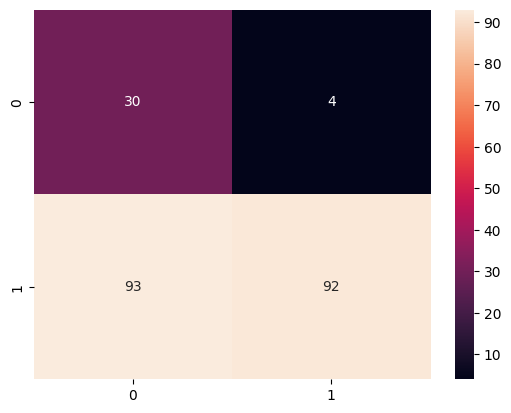

In [ ]:
sns.heatmap(confusion_matrix(y_test, y_pred_test), annot=True)

In [ ]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, f1_score

clf = LogisticRegression(C=0.1, max_iter=10000)
clf.fit(X_train, y_train)
y_pred_test = clf.predict(X_test)

print('TEST ERROR')
print(f'Accuracy score: {accuracy_score(y_test, y_pred_test)}')
print(f'F1 score: {f1_score(y_test, y_pred_test, pos_label=0)}')

TEST ERROR
Accuracy score: 0.6484018264840182
F1 score: 0.34188034188034183


<Axes: >

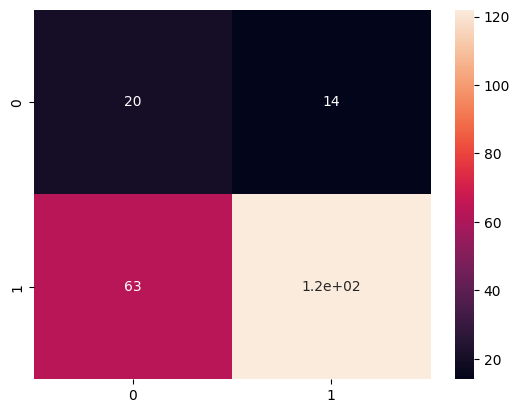

In [ ]:
sns.heatmap(confusion_matrix(y_test, y_pred_test), annot=True)

In [ ]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, f1_score

clf = RandomForestClassifier(n_estimators=300, criterion='entropy', max_depth=13)
clf.fit(X_train, y_train)
y_pred_test = clf.predict(X_test)

print('TEST ERROR')
print(f'Accuracy score: {accuracy_score(y_test, y_pred_test)}')
print(f'F1 score: {f1_score(y_test, y_pred_test, pos_label=0)}')

TEST ERROR
Accuracy score: 0.684931506849315
F1 score: 0.4201680672268907


<Axes: >

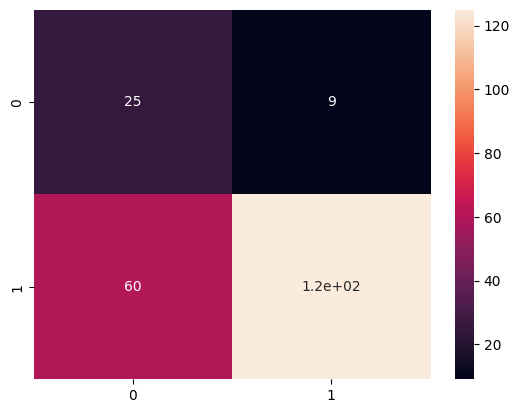

In [ ]:
sns.heatmap(confusion_matrix(y_test, y_pred_test), annot=True)

In [ ]:
from xgboost import XGBClassifier
from sklearn.metrics import accuracy_score, f1_score

reg = XGBClassifier(max_depth=15)
reg.fit(X_train, y_train)
y_pred_test = reg.predict(X_test)

print('TEST ERROR')
print(f'Accuracy score: {accuracy_score(y_test, y_pred_test)}')
print(f'F1 score: {f1_score(y_test, y_pred_test, pos_label=0)}')

TEST ERROR
Accuracy score: 0.6986301369863014
F1 score: 0.42105263157894735


<Axes: >

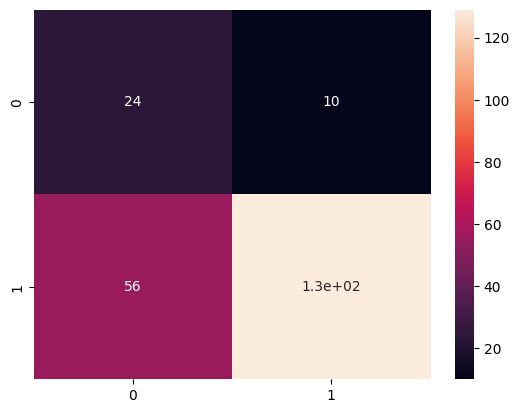

In [ ]:
sns.heatmap(confusion_matrix(y_test, y_pred_test), annot=True)

In [ ]:
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score, f1_score

reg = SVC()
reg.fit(X_train, y_train)
y_pred_test = reg.predict(X_test)

print('TEST ERROR')
print(f'Accuracy score: {accuracy_score(y_test, y_pred_test)}')
print(f'F1 score: {f1_score(y_test, y_pred_test, pos_label=0)}')

TEST ERROR
Accuracy score: 0.4383561643835616
F1 score: 0.28070175438596495


<Axes: >

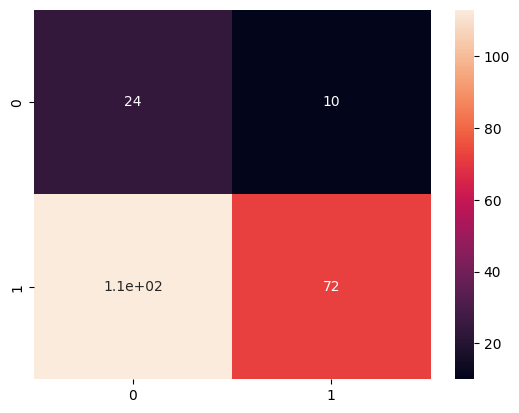

In [ ]:
sns.heatmap(confusion_matrix(y_test, y_pred_test), annot=True)

In [ ]:
from keras.models import Sequential
from keras.layers import Dense, Dropout
import tensorflow as tf


model = Sequential()
model.add(Dense(64, input_dim=15, activation='relu'))
model.add(Dropout(0.1))
model.add(Dense(32, activation='relu'))
model.add(Dense(1, activation='sigmoid'))

model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['acc'])
history = model.fit(X_train, y_train, epochs=50, batch_size=8, validation_data=(X_test, y_test))

y_pred_test = model.predict(X_test)
y_pred = list([0 if el[0]<=0.5 else 1 for el in y_pred_test])
print('TEST ERROR')
print(f'Accuracy score: {accuracy_score(y_test, y_pred)}')
print(f'F1 score: {f1_score(y_test, y_pred, pos_label=0)}')

Epoch 1/50
42/42 [==============================] - 1s 8ms/step - loss: 1.2757 - acc: 0.4405 - val_loss: 0.6207 - val_acc: 0.6758
Epoch 2/50
42/42 [==============================] - 0s 3ms/step - loss: 0.9577 - acc: 0.5387 - val_loss: 0.8689 - val_acc: 0.4658
Epoch 3/50
42/42 [==============================] - 0s 4ms/step - loss: 0.8978 - acc: 0.5119 - val_loss: 0.7114 - val_acc: 0.5251
Epoch 4/50
42/42 [==============================] - 0s 4ms/step - loss: 0.8523 - acc: 0.5327 - val_loss: 0.7479 - val_acc: 0.4521
Epoch 5/50
42/42 [==============================] - 0s 4ms/step - loss: 0.8349 - acc: 0.5417 - val_loss: 0.8531 - val_acc: 0.2785
Epoch 6/50
42/42 [==============================] - 0s 4ms/step - loss: 0.8181 - acc: 0.5149 - val_loss: 0.7055 - val_acc: 0.5434
Epoch 7/50
42/42 [==============================] - 0s 4ms/step - loss: 0.7696 - acc: 0.5536 - val_loss: 0.7425 - val_acc: 0.4521
Epoch 8/50
42/42 [==============================] - 0s 4ms/step - loss: 0.7631 - acc: 0.57

<Axes: >

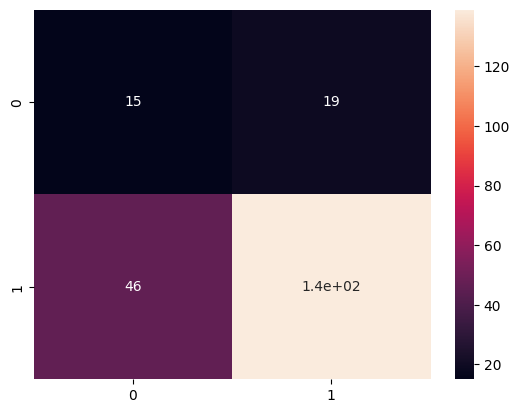

In [ ]:
sns.heatmap(confusion_matrix(y_test, y_pred), annot=True)

### SMOTE-ENC oversampling

Oversampling shows even better performance than undersampling especially on the deep learning(because deep learning needs more data).

In [ ]:
from sklearn.preprocessing import LabelEncoder

X_train, X_test, y_train, y_test = split_and_preprocess(df_clean, target='accidents', sample='over')
enc = LabelEncoder()
y_train = enc.fit_transform(y_train)
y_test = enc.transform(y_test)

X_train.head()

,price,ext_color,int_color,drivetrain,mpg,fuel,mileage,1owner,personal_use,year,make,model,engine_size,engine_type,review
0,-0.699347,0.0,4.0,2,1.747679,1,0.514076,1,1,0.427008,17.0,102.0,-1.149968,3.0,-0.572566
1,0.160444,0.0,0.0,1,-0.486559,1,-0.293401,1,0,-0.388544,39.0,2.0,0.263041,7.0,0.357934
2,-0.378984,8.0,0.0,2,-0.060990,1,0.159626,1,1,-0.796320,8.0,287.0,0.263041,7.0,1.646317
3,0.616204,8.0,0.0,3,-1.231305,1,-0.526918,1,0,-0.796320,7.0,266.0,-0.207962,8.0,-1.073604
4,-0.545440,8.0,0.0,0,-0.060990,1,-0.080718,1,0,0.630896,32.0,56.0,0.184540,7.0,0.286357


In [ ]:
from mixed_naive_bayes import MixedNB
from sklearn.metrics import accuracy_score, f1_score

clf = MixedNB(categorical_features=[1,2,3, 5,7,8,10,11,13])
clf.fit(X_train, y_train)
y_pred_test = clf.predict(X_test)

print('TEST ERROR')
print(f'Accuracy score: {accuracy_score(y_test, y_pred_test)}')
print(f'F1 score: {f1_score(y_test, y_pred_test, pos_label=0)}')

TEST ERROR
Accuracy score: 0.7031963470319634
F1 score: 0.36893203883495146


<Axes: >

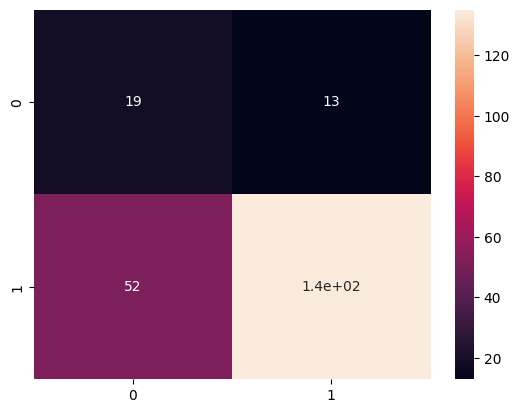

In [ ]:
sns.heatmap(confusion_matrix(y_test, y_pred_test), annot=True)

In [ ]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, f1_score

clf = LogisticRegression(C=0.1, max_iter=10000)
clf.fit(X_train, y_train)
y_pred_test = clf.predict(X_test)

print('TEST ERROR')
print(f'Accuracy score: {accuracy_score(y_test, y_pred_test)}')
print(f'F1 score: {f1_score(y_test, y_pred_test, pos_label=0)}')

TEST ERROR
Accuracy score: 0.6484018264840182
F1 score: 0.3063063063063063


<Axes: >

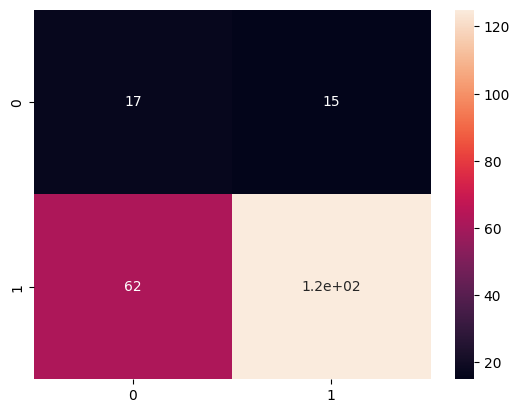

In [ ]:
sns.heatmap(confusion_matrix(y_test, y_pred_test), annot=True)

In [ ]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, f1_score

clf = RandomForestClassifier(n_estimators=300, criterion='entropy', max_depth=13)
clf.fit(X_train, y_train)
y_pred_test = clf.predict(X_test)

print('TEST ERROR')
print(f'Accuracy score: {accuracy_score(y_test, y_pred_test)}')
print(f'F1 score: {f1_score(y_test, y_pred_test, pos_label=0)}')

TEST ERROR
Accuracy score: 0.8356164383561644
F1 score: 0.47058823529411764


<Axes: >

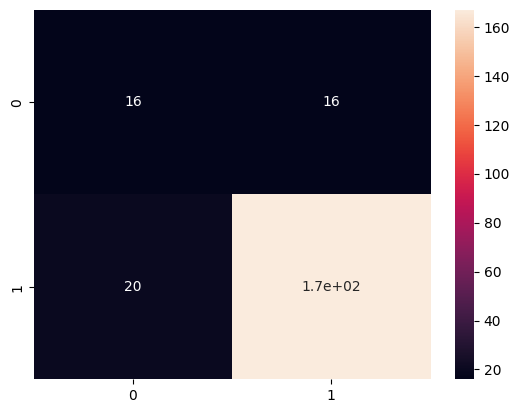

In [ ]:
sns.heatmap(confusion_matrix(y_test, y_pred_test), annot=True)

In [ ]:
from xgboost import XGBClassifier
from sklearn.metrics import accuracy_score, f1_score

reg = XGBClassifier(max_depth=15)
reg.fit(X_train, y_train)
y_pred_test = reg.predict(X_test)

print('TEST ERROR')
print(f'Accuracy score: {accuracy_score(y_test, y_pred_test)}')
print(f'F1 score: {f1_score(y_test, y_pred_test, pos_label=0)}')

TEST ERROR
Accuracy score: 0.8036529680365296
F1 score: 0.37681159420289856


<Axes: >

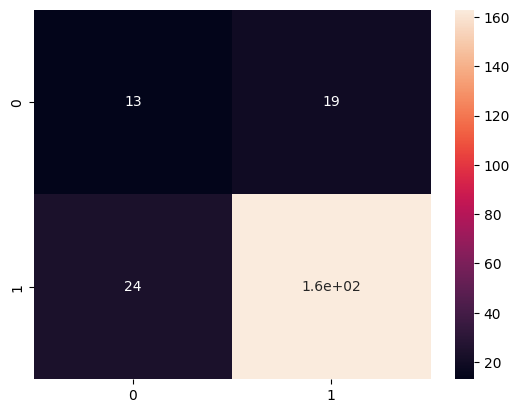

In [ ]:
sns.heatmap(confusion_matrix(y_test, y_pred_test), annot=True)

In [ ]:
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score, f1_score

reg = SVC()
reg.fit(X_train, y_train)
y_pred_test = reg.predict(X_test)

print('TEST ERROR')
print(f'Accuracy score: {accuracy_score(y_test, y_pred_test)}')
print(f'F1 score: {f1_score(y_test, y_pred_test, pos_label=0)}')

TEST ERROR
Accuracy score: 0.6255707762557078
F1 score: 0.2545454545454545


<Axes: >

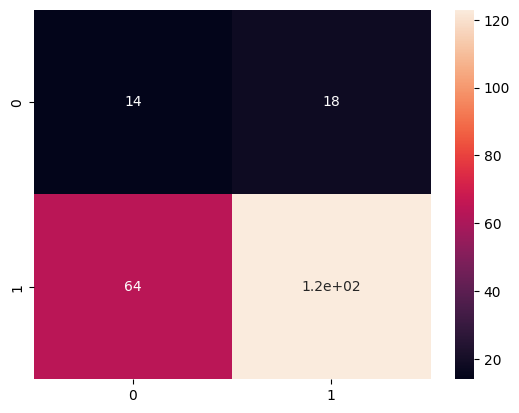

In [ ]:
sns.heatmap(confusion_matrix(y_test, y_pred_test), annot=True)

In [ ]:
from keras.models import Sequential
from keras.layers import Dense, Dropout
import tensorflow as tf


model = Sequential()
model.add(Dense(64, input_dim=15, activation='relu'))
model.add(Dropout(0.1))
model.add(Dense(32, activation='relu'))
model.add(Dense(1, activation='sigmoid'))

model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['acc'])
history = model.fit(X_train, y_train, epochs=50, batch_size=8, validation_data=(X_test, y_test))

y_pred_test = model.predict(X_test)
y_pred = list([0 if el[0]<=0.5 else 1 for el in y_pred_test])
print('TEST ERROR')
print(f'Accuracy score: {accuracy_score(y_test, y_pred)}')
print(f'F1 score: {f1_score(y_test, y_pred, pos_label=0)}')

Epoch 1/50
177/177 [==============================] - 1s 3ms/step - loss: 1.9190 - acc: 0.5014 - val_loss: 0.5454 - val_acc: 0.7489
Epoch 2/50
177/177 [==============================] - 0s 2ms/step - loss: 1.1126 - acc: 0.5447 - val_loss: 1.1154 - val_acc: 0.2374
Epoch 3/50
177/177 [==============================] - 0s 2ms/step - loss: 0.9368 - acc: 0.5213 - val_loss: 0.5620 - val_acc: 0.7808
Epoch 4/50
177/177 [==============================] - 0s 2ms/step - loss: 0.7611 - acc: 0.5879 - val_loss: 0.6846 - val_acc: 0.5799
Epoch 5/50
177/177 [==============================] - 0s 2ms/step - loss: 0.7836 - acc: 0.5610 - val_loss: 0.5546 - val_acc: 0.7489
Epoch 6/50
177/177 [==============================] - 0s 2ms/step - loss: 0.7426 - acc: 0.5830 - val_loss: 0.5611 - val_acc: 0.7534
Epoch 7/50
177/177 [==============================] - 0s 3ms/step - loss: 0.7039 - acc: 0.6007 - val_loss: 0.6430 - val_acc: 0.6621
Epoch 8/50
177/177 [==============================] - 1s 3ms/step - loss: 0.

<Axes: >

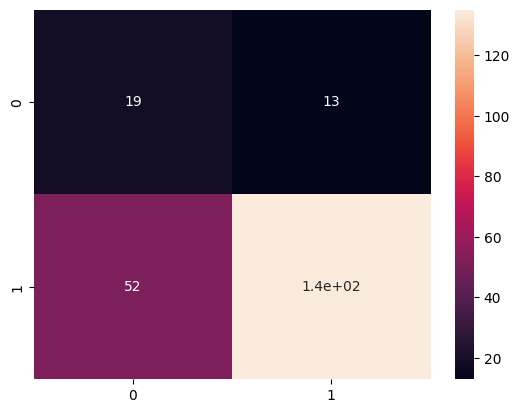

In [ ]:
sns.heatmap(confusion_matrix(y_test, y_pred), annot=True)

### Sampling by clustering
The main idea is to downsample by using more representative samples. My idea is to cluster the the majority class and obtain one sample of each cluster. That way each cluster is more informative than just random sampling. I decided to go with Agglomerative clustering as that seemed the best method from the section "Clustering" below. It shows better results than just random undersampling

In [ ]:
from sklearn.preprocessing import LabelEncoder

X_train, X_test, y_train, y_test = split_and_preprocess(df_clean, target='accidents', sample='cluster')
enc = LabelEncoder()
y_train = enc.fit_transform(y_train)
y_test = enc.transform(y_test)

X_train.head()

,price,ext_color,int_color,drivetrain,mpg,fuel,mileage,1owner,personal_use,year,make,model,engine_size,engine_type,review
0,-0.001255,1.0,0.0,0,0.552339,1,-0.632933,0,0,-0.778461,30.0,87.0,-0.977131,3.0,-1.008810
1,-0.248788,5.0,0.0,2,1.907853,1,0.032868,0,0,-0.618834,38.0,51.0,-0.613912,3.0,0.533998
2,-0.214093,1.0,0.0,0,-0.028596,1,-0.239790,1,0,-0.139953,36.0,203.0,-0.977131,0.0,-0.405102
3,-0.567860,0.0,0.0,2,-0.125419,1,2.770153,1,0,0.658182,5.0,157.0,-0.831843,3.0,-0.606338
4,0.378668,5.0,0.0,3,-0.512709,1,-0.073595,1,1,-0.139953,30.0,161.0,0.984253,8.0,-0.606338


In [ ]:
from mixed_naive_bayes import MixedNB
from sklearn.metrics import accuracy_score, f1_score

clf = MixedNB(categorical_features=[1,2,3, 5,7,8,10,11,13])
clf.fit(X_train, y_train)
y_pred_test = clf.predict(X_test)

print('TEST ERROR')
print(f'Accuracy score: {accuracy_score(y_test, y_pred_test)}')
print(f'F1 score: {f1_score(y_test, y_pred_test, pos_label=0)}')

TEST ERROR
Accuracy score: 0.547945205479452
F1 score: 0.44067796610169496


<Axes: >

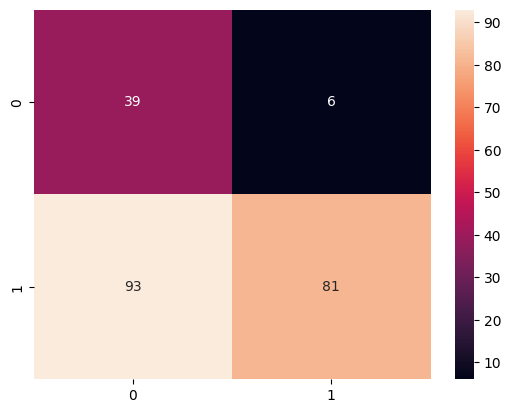

In [ ]:
sns.heatmap(confusion_matrix(y_test, y_pred_test), annot=True)

In [ ]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, f1_score

clf = LogisticRegression(C=0.1, max_iter=10000)
clf.fit(X_train, y_train)
y_pred_test = clf.predict(X_test)

print('TEST ERROR')
print(f'Accuracy score: {accuracy_score(y_test, y_pred_test)}')
print(f'F1 score: {f1_score(y_test, y_pred_test, pos_label=0)}')

TEST ERROR
Accuracy score: 0.634703196347032
F1 score: 0.3442622950819672


<Axes: >

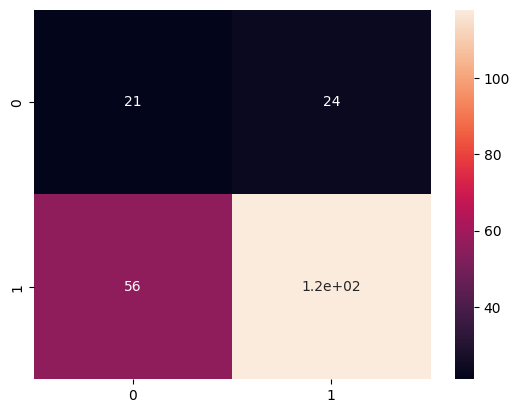

In [ ]:
sns.heatmap(confusion_matrix(y_test, y_pred_test), annot=True)

In [ ]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, f1_score

clf = RandomForestClassifier(n_estimators=300, criterion='entropy', max_depth=10)
clf.fit(X_train, y_train)
y_pred_test = clf.predict(X_test)

print('TEST ERROR')
print(f'Accuracy score: {accuracy_score(y_test, y_pred_test)}')
print(f'F1 score: {f1_score(y_test, y_pred_test, pos_label=0)}')

TEST ERROR
Accuracy score: 0.7077625570776256
F1 score: 0.49206349206349204


<Axes: >

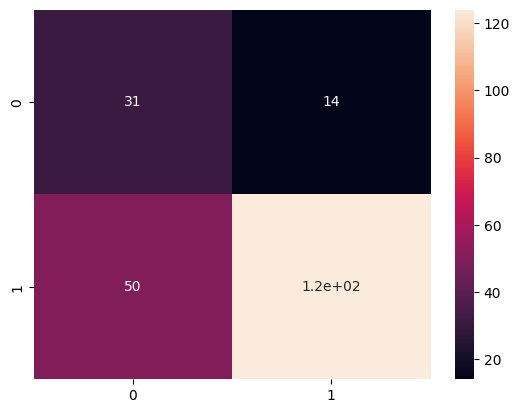

In [ ]:
sns.heatmap(confusion_matrix(y_test, y_pred_test), annot=True)

In [ ]:
from xgboost import XGBClassifier
from sklearn.metrics import accuracy_score, f1_score

reg = XGBClassifier(max_depth=11)
reg.fit(X_train, y_train)
y_pred_test = reg.predict(X_test)

print('TEST ERROR')
print(f'Accuracy score: {accuracy_score(y_test, y_pred_test)}')
print(f'F1 score: {f1_score(y_test, y_pred_test, pos_label=0)}')

TEST ERROR
Accuracy score: 0.6438356164383562
F1 score: 0.4347826086956521


<Axes: >

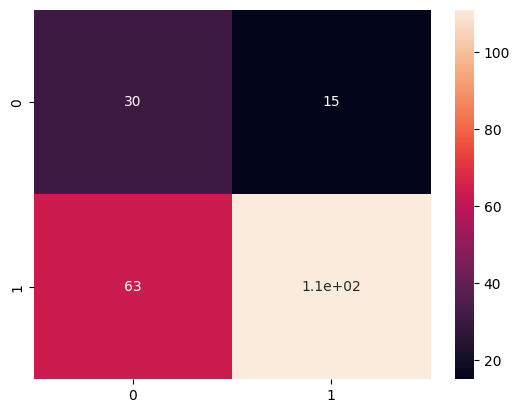

In [ ]:
sns.heatmap(confusion_matrix(y_test, y_pred_test), annot=True)

In [ ]:
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score, f1_score

reg = SVC()
reg.fit(X_train, y_train)
y_pred_test = reg.predict(X_test)

print('TEST ERROR')
print(f'Accuracy score: {accuracy_score(y_test, y_pred_test)}')
print(f'F1 score: {f1_score(y_test, y_pred_test, pos_label=0)}')

TEST ERROR
Accuracy score: 0.7945205479452054
F1 score: 0.0


<Axes: >

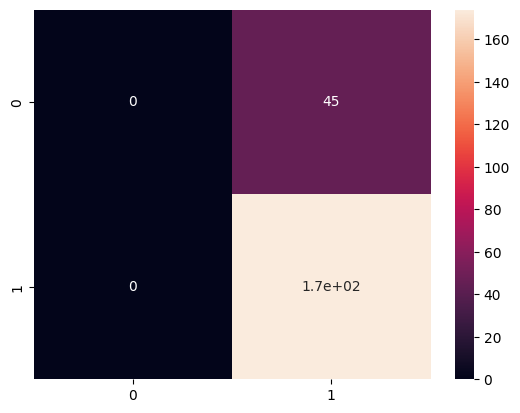

In [ ]:
sns.heatmap(confusion_matrix(y_test, y_pred_test), annot=True)

In [ ]:
from keras.models import Sequential
from keras.layers import Dense, Dropout
import tensorflow as tf


model = Sequential()
model.add(Dense(64, input_dim=15, activation='relu'))
model.add(Dropout(0.1))
model.add(Dense(32, activation='relu'))
model.add(Dense(1, activation='sigmoid'))

model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['acc'])
history = model.fit(X_train, y_train, epochs=50, batch_size=8, validation_data=(X_test, y_test))

y_pred_test = model.predict(X_test)
y_pred = list([0 if el[0]<=0.5 else 1 for el in y_pred_test])
print('TEST ERROR')
print(f'Accuracy score: {accuracy_score(y_test, y_pred)}')
print(f'F1 score: {f1_score(y_test, y_pred, pos_label=0)}')

Epoch 1/50
45/45 [==============================] - 2s 11ms/step - loss: 1.6425 - acc: 0.4930 - val_loss: 0.9268 - val_acc: 0.4338
Epoch 2/50
45/45 [==============================] - 0s 3ms/step - loss: 1.0760 - acc: 0.5238 - val_loss: 0.6157 - val_acc: 0.6895
Epoch 3/50
45/45 [==============================] - 0s 4ms/step - loss: 1.1193 - acc: 0.4930 - val_loss: 0.7039 - val_acc: 0.5205
Epoch 4/50
45/45 [==============================] - 0s 5ms/step - loss: 0.9164 - acc: 0.5518 - val_loss: 0.6229 - val_acc: 0.6986
Epoch 5/50
45/45 [==============================] - 0s 4ms/step - loss: 0.8561 - acc: 0.5518 - val_loss: 0.6968 - val_acc: 0.5342
Epoch 6/50
45/45 [==============================] - 0s 3ms/step - loss: 0.8695 - acc: 0.5154 - val_loss: 1.1103 - val_acc: 0.3470
Epoch 7/50
45/45 [==============================] - 0s 4ms/step - loss: 0.8361 - acc: 0.5462 - val_loss: 1.0855 - val_acc: 0.3105
Epoch 8/50
45/45 [==============================] - 0s 4ms/step - loss: 0.8127 - acc: 0.5

<Axes: >

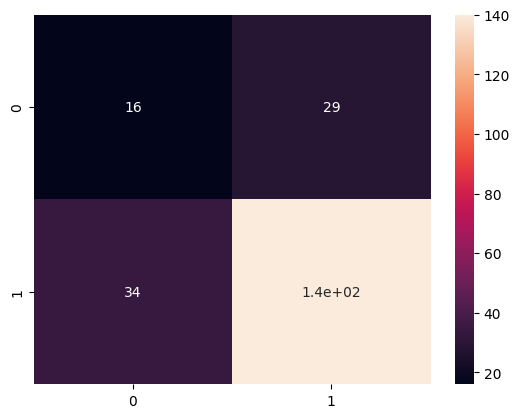

In [ ]:
sns.heatmap(confusion_matrix(y_test, y_pred), annot=True)

# Clustering
Clustering does not show clear results after PCA, and is hard to interperet. But it still does work, as better results were achieved on th

## Gowers distance

In [ ]:
!pip install gower scikit-learn-extra

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.0/2.0 MB 35.0 MB/s eta 0:00:00


In [ ]:
import gower

dist_matrix = gower.gower_matrix(df_clean)

### K-Means (K-medoids)

In [ ]:
from sklearn_extra.cluster import KMedoids

cluster_range = range(1, 21)
inertias = []
for n_clusters in cluster_range:
    kmeans = KMedoids(n_clusters=n_clusters,
                           metric='precomputed',
                           method='pam', init='build').fit(dist_matrix)
    inertias.append(kmeans.inertia_)

/usr/local/lib/python3.10/dist-packages/sklearn_extra/cluster/_k_medoids.py:252: UserWarning: n_clusters should be larger than 2 if max_iter != 0 setting max_iter to 0.
  warnings.warn(


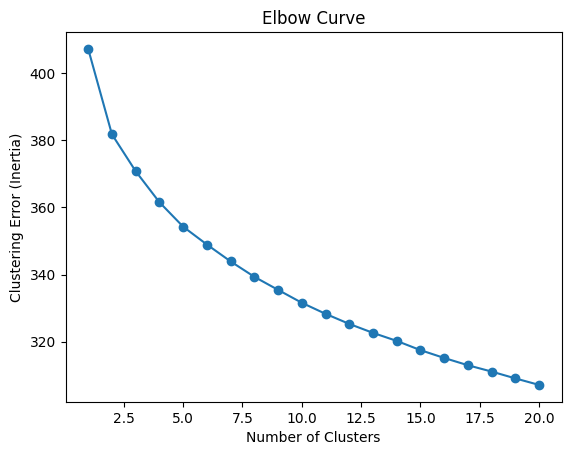

In [ ]:
import matplotlib.pyplot as plt

plt.plot(cluster_range, inertias, marker='o')
plt.xlabel('Number of Clusters')
plt.ylabel('Clustering Error (Inertia)')
plt.title('Elbow Curve')
plt.show()

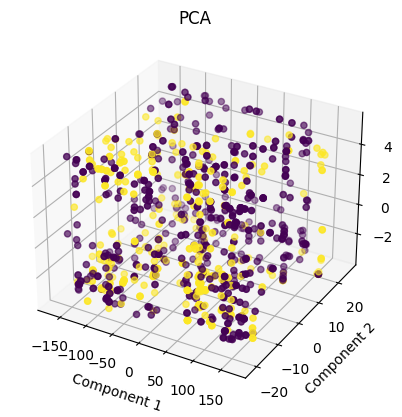

In [ ]:
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from sklearn.decomposition import PCA


kmeans = KMedoids(n_clusters=2,
                           metric='precomputed',
                           method='pam', init='build').fit(dist_matrix)

data, _, _, _ = split_and_preprocess(df_clean, target=None)

pca = PCA(n_components=3)
pca_data = pca.fit_transform(data)

fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
ax.scatter(pca_data[:, 0], pca_data[:, 1], pca_data[:, 2], c=kmeans.labels_)
ax.set_xlabel('Component 1')
ax.set_ylabel('Component 2')
ax.set_zlabel('Component 3')
plt.title('PCA')
plt.show()


In [ ]:
def display_cluster_samples(X, cluster_labels, cluster_num, num_samples=15):
    cluster_samples = X[cluster_labels == cluster_num]

    return cluster_samples.head(num_samples)
display_cluster_samples(df_clean, kmeans.labels_,0)

,price,name,ext_color,int_color,drivetrain,mpg,fuel,transmission,engine,mileage,...,review_value,review_styling,review_reliability,sellers-notes,year,make,model,engine_size,engine_type,review
0,33991,2022 Subaru Ascent Premium 8-Passenger,black,black,All-wheel Drive,24.000000,Gasoline,Automatic CVT,2.4L H4 16V GDI DOHC Turbo,13955.0,...,3.9,4.0,4.2,"Clean CARFAX. CARFAX One-Owner. Backup Camera,...",1,Subaru,Ascent,2.4,H4,4.133333
1,25400,2020 Toyota Camry Hybrid XLE,blue,black,Front-wheel Drive,45.500000,Hybrid,Automatic CVT,2.5L I4 16V PDI DOHC Hybrid,93794.0,...,4.4,4.9,4.6,"Come see us in beautiful Ardmore, OK USA! Take...",3,Toyota,Camry,2.5,I4,4.666667
4,54894,2023 Acura MDX A-Spec,blue,black,All-wheel Drive,22.000000,Gasoline,10-Speed Automatic,3.5L V6 24V GDI SOHC,2256.0,...,4.5,4.8,4.7,2023 Acura MDX A-Spec SH-AWD Certified. NAVIGA...,0,Acura,MDX,3.5,V6,4.666667
6,13995,2015 Nissan Juke NISMO RS,black,black,Front-wheel Drive,28.000000,Gasoline,6-Speed Manual,1.6L I4 16V GDI DOHC Turbo,86598.0,...,4.6,4.9,4.8,Schedule Virtual Appointment & Home Delivery A...,8,Nissan,Juke,1.6,I4,4.733333
7,26095,2022 Chevrolet Trailblazer LT,white,black,Front-wheel Drive,30.000000,Gasoline,Automatic CVT,1.3L I3 12V GDI DOHC Turbo,14293.0,...,3.7,4.7,4.7,Priced below KBB Fair Purchase Price! Recent A...,1,Chevrolet,Trailblazer,1.3,I3,4.516667
10,41358,2021 INFINITI Q60 3.0t Red Sport 400,white,graphite,All-wheel Drive,22.500000,Gasoline,7-Speed Automatic,3.0L V6 24V GDI DOHC Twin Turbo,40298.0,...,5.0,5.0,5.0,"2021 INFINITI Q60 Red Sport 400 Coupe,Majestic...",2,INFINITI,Q60,3.0,V6,5.000000
11,34000,2022 Hyundai Santa Cruz 2.5T SEL Premium,white,black,All-wheel Drive,23.641939,Gasoline,SHIFTRONIC,2.5L I4 16V PDI DOHC Turbo,5104.0,...,3.9,4.7,4.2,Hyundai Certified Used VehicleMoonroofBackup C...,1,Hyundai,Santa,2.5,I4,4.300000
12,270977,2020 Lamborghini Huracan EVO Base,white,black,Rear-wheel Drive,15.500000,Gasoline,7-Speed Automatic with Auto-Shift,5.2L V10 40V GDI DOHC,7090.0,...,3.0,5.0,5.0,"Located @AristocratMotors.com in Merriam, KS! ...",3,Lamborghini,Huracan,5.2,I4,4.500000
14,29900,2014 BMW M6 Base,grey,silver,Rear-wheel Drive,17.000000,Gasoline,7-Speed Automatic with Auto-Shift,4.4L V8 32V GDI DOHC Twin Turbo,46986.0,...,4.9,4.9,4.8,THIS IS A FRESH TRADE THAT HAS NOT AND WILL NO...,9,BMW,M6,4.4,V8,4.883333
19,11995,2014 Mazda Mazda5 Grand Touring,blue,black,Front-wheel Drive,25.000000,Gasoline,5-Speed Automatic,2.5L I4 16V MPFI DOHC,89256.0,...,4.5,4.5,4.6,CARFAX One-Owner. Clean CARFAX. Deep Crystal B...,9,Mazda,Mazda5,2.5,I4,4.433333


### Agglomerative clustering

In [ ]:
from sklearn.cluster import AgglomerativeClustering
from sklearn.metrics import silhouette_score

cluster_range = range(2, 25)
sils = []
for n_clusters in cluster_range:
    clustering = AgglomerativeClustering(n_clusters=n_clusters, metric='precomputed', linkage='complete').fit(dist_matrix)
    np.fill_diagonal(dist_matrix, 0)
    sils.append(silhouette_score(dist_matrix, clustering.labels_, metric='precomputed'))


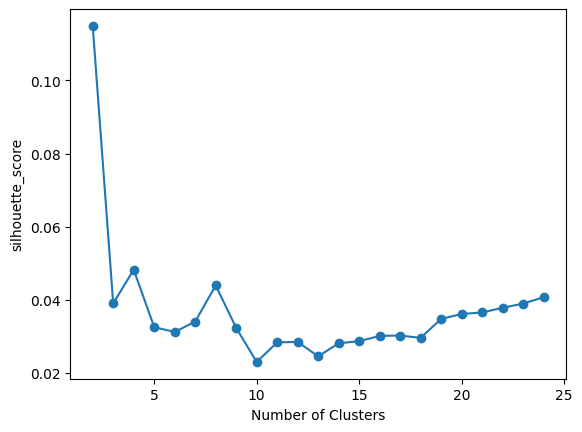

In [ ]:
import matplotlib.pyplot as plt

plt.plot(cluster_range, sils, marker='o')
plt.xlabel('Number of Clusters')
plt.ylabel('silhouette_score')
plt.show()

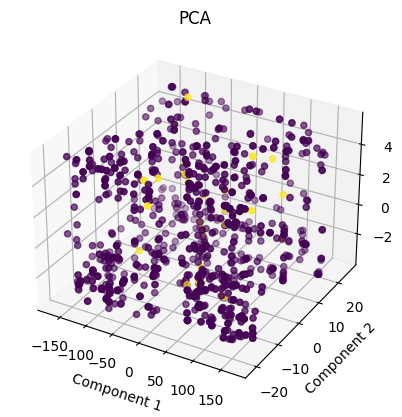

In [ ]:
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from sklearn.decomposition import PCA


clustering = AgglomerativeClustering(n_clusters=2, metric='precomputed', linkage='complete').fit(dist_matrix)

data, _, _, _ = split_and_preprocess(df_clean, target=None)

pca = PCA(n_components=3)
pca_data = pca.fit_transform(data)

fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
ax.scatter(pca_data[:, 0], pca_data[:, 1], pca_data[:, 2], c=clustering.labels_)
ax.set_xlabel('Component 1')
ax.set_ylabel('Component 2')
ax.set_zlabel('Component 3')
plt.title('PCA')
plt.show()


In [ ]:
display_cluster_samples(df_clean, clustering.labels_, 1)

,price,name,ext_color,int_color,drivetrain,mpg,fuel,transmission,engine,mileage,...,review_value,review_styling,review_reliability,sellers-notes,year,make,model,engine_size,engine_type,review
71,51673,2022 Tesla Model Y Long Range,silver,black,All-wheel Drive,23.641939,Gasoline,Electric,7SAYGDEE9NF437047,0.000002,...,3.6,4.2,3.5,Clean CARFAX. Midnight Silver Metallic 2022 Te...,1,Tesla,Model,3.0,I4,3.900000
100,26000,2022 Honda HR-V Sport,white,black,All-wheel Drive,28.500000,Gasoline,Automatic CVT,1.8L I4 16V MPFI SOHC,13267.000000,...,3.6,4.2,4.2,"2022 Honda HR-V Sport AWD Local trade, Great S...",1,Honda,HR-V,1.8,I4,3.766667
172,55900,2022 Tesla Model Y Performance,silver,black,All-wheel Drive,23.641939,Gasoline,Electric,7SAYGDEF8NF375875,0.000029,...,3.6,4.2,3.5,"REDUCED $71,000 Org MSRP Performance pkg, Auto...",1,Tesla,Model,3.0,I4,3.900000
190,29000,2023 Honda Civic Sport,white,black,Front-wheel Drive,23.641939,Gasoline,Automatic CVT,2.0L I4 16V GDI DOHC,2414.000000,...,4.0,4.0,5.0,"Clean CARFAX. CARFAX One-Owner. Civic Sport, A...",0,Honda,Civic,2.0,I4,4.333333
252,56499,2022 Mercedes-Benz E-Class E 350,blue,black,Rear-wheel Drive,23.641939,Gasoline,9-Speed Automatic,2.0L I4 16V GDI DOHC Turbo,4508.000000,...,4.0,4.0,4.0,CERTIFIED UNLIMITED MILEAGE COVERAGE 2022 E350...,1,Mercedes-Benz,E-Class,2.0,I4,3.666667
253,54450,2022 Jeep Grand Cherokee L Overland,white,black,Four-wheel Drive,23.641939,Gasoline,8-Speed Automatic,3.6L V6 24V MPFI DOHC,19188.000000,...,3.3,4.3,3.6,2022 Jeep Grand Cherokee L Overland PRICE REDU...,1,Jeep,Grand,3.6,V6,3.850000
307,56499,2022 Mercedes-Benz E-Class E 350,blue,black,Rear-wheel Drive,23.641939,Gasoline,9-Speed Automatic,2.0L I4 16V GDI DOHC Turbo,4508.000000,...,4.0,4.0,4.0,CERTIFIED UNLIMITED MILEAGE COVERAGE 2022 E350...,1,Mercedes-Benz,E-Class,2.0,I4,3.666667
378,35835,2023 Acura Integra A-Spec Technology,blue,black,Front-wheel Drive,32.500000,Gasoline,Automatic CVT,1.5L I4 16V GDI DOHC Turbo,905.000000,...,4.2,5.0,4.8,2023 Acura Integra A-Spec Tech Package Certifi...,0,Acura,Integra,1.5,I4,4.566667
428,32195,2022 Volvo S60 B5,silver,black,Front-wheel Drive,30.500000,Gasoline,8-Speed Automatic,2.0L I4 16V GDI DOHC Turbo,12500.000000,...,4.0,5.0,4.0,Priced below KBB Fair Purchase Price! 2022 Vol...,1,Volvo,S60,2.0,I4,4.083333
522,30200,2022 Volkswagen Tiguan 2.0T SE,grey,black,Front-wheel Drive,26.500000,Gasoline,8-Speed Automatic,2.0L I4 16V GDI DOHC Turbo,7786.000000,...,3.1,3.9,3.5,Gray 2022 Volkswagen Tiguan 2.0T SE FWD 8-Spee...,1,Volkswagen,Tiguan,2.0,I4,3.600000


## Drop categorical features

### K-Means

In [ ]:
df_drop = df_clean.drop(['name', 'ext_color', 'int_color', 'drivetrain', 'fuel', 'transmission', 'engine', 'sellers-notes', 'make', 'model', 'engine_type', 'accidents', '1owner', 'personal_use', 'review_comfort', 'review_design', 'review_performance', 'review_value', 'review_styling', 'review_reliability'],axis=1)

sc = StandardScaler()
sc.fit(df_drop)
df_drop = sc.transform(df_drop)
df_drop.shape

(1094, 6)

In [ ]:
from sklearn.cluster import KMeans

cluster_range = range(1, 21)
inertias = []
for n_clusters in cluster_range:
    kmeans = KMeans(n_clusters=n_clusters).fit(df_drop)
    inertias.append(kmeans.inertia_)

/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:8

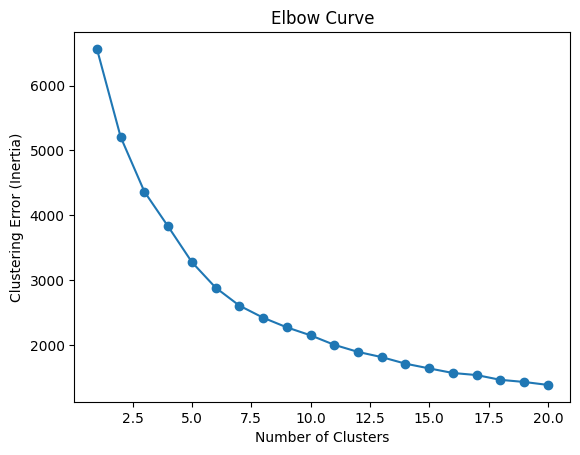

In [ ]:
import matplotlib.pyplot as plt

plt.plot(cluster_range, inertias, marker='o')
plt.xlabel('Number of Clusters')
plt.ylabel('Clustering Error (Inertia)')
plt.title('Elbow Curve')
plt.show()

/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


<Axes: >

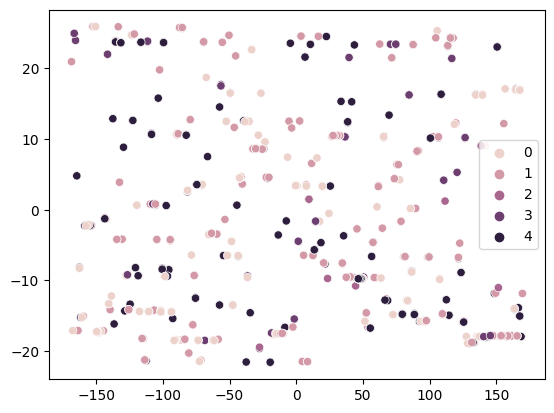

In [ ]:
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from sklearn.decomposition import PCA
import seaborn as sns


kmeans = KMeans(n_clusters=5).fit(df_drop)

data, _, _, _ = split_and_preprocess(df_clean, target=None)

pca = PCA(n_components=2)
pca_data = pca.fit_transform(data)

sns.scatterplot(x=pca_data[:,0], y=pca_data[:,1], hue=kmeans.labels_)


### Agglomerative

In [ ]:
from sklearn.cluster import AgglomerativeClustering
from sklearn.metrics import silhouette_score

cluster_range = range(2, 25)
sils = []
for n_clusters in cluster_range:
    clustering = AgglomerativeClustering(n_clusters=n_clusters, linkage='complete').fit(df_drop)
    sils.append(silhouette_score(df_drop, clustering.labels_))


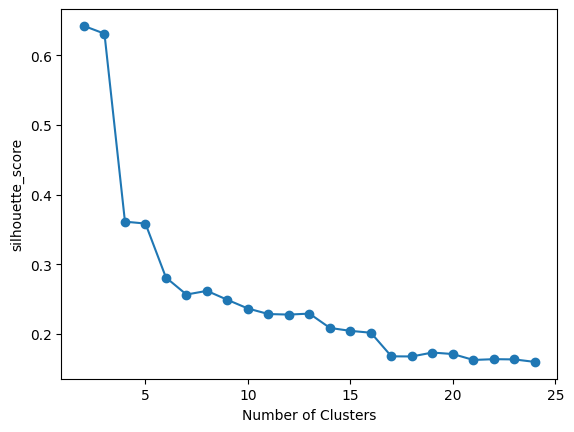

In [ ]:
import matplotlib.pyplot as plt

plt.plot(cluster_range, sils, marker='o')
plt.xlabel('Number of Clusters')
plt.ylabel('silhouette_score')
plt.show()

<Axes: >

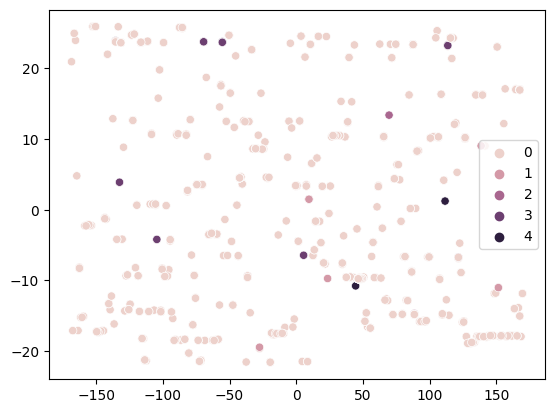

In [ ]:
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from sklearn.decomposition import PCA
import seaborn as sns


agg = AgglomerativeClustering(n_clusters=5, linkage='complete').fit(df_drop)

data, _, _, _ = split_and_preprocess(df_clean, target=None)

pca = PCA(n_components=2)
pca_data = pca.fit_transform(data)

sns.scatterplot(x=pca_data[:,0], y=pca_data[:,1], hue=agg.labels_)


# Problems encountered
- Naive bayes on mixed categorical and numerical data
- Too many unique labels for labelEncoder (used OrdinalEncoder) - data leakage
- Sampling imbalanced